In [436]:
import pandas as pd
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import category_encoders as ce
import pickle
import optuna
import warnings
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

In [231]:
warnings.filterwarnings('ignore')

In [232]:
plt.style.use('seaborn-v0_8')

## 1. Анализ и обработка данных

### Чтение данных

In [233]:
# прочитаем данные
data = pd.read_csv('data.csv')
data.head()

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


In [234]:
print(f'Кол-во строк: {data.shape[0]}, кол-во признаков: {data.shape[1]}.')

Кол-во строк: 377185, кол-во признаков: 18.


#### Набор данных содержит следующие столбцы:

 - 'status' — статус продажи;
 - 'private pool' и 'PrivatePool' — наличие собственного бассейна;
 - 'propertyType' — тип объекта недвижимости;
 - 'street' — адрес объекта;
 - 'baths' — количество ванных комнат;
 - 'homeFacts' — сведения о строительстве объекта (содержит несколько типов сведений, влияющих на оценку объекта);
 - 'fireplace' — наличие камина;
 - 'city' — город;
 - 'schools' — сведения о школах в районе;
 - 'sqft' — площадь в футах;
 - 'zipcode' — почтовый индекс;
 - 'beds' — количество спален;
 - 'state' — штат;
 - 'stories' — количество этажей;
 - 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система мультилистинга);
 - 'target' — цена объекта недвижимости (целевой признак, который необходимо спрогнозировать).

In [235]:
# информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

#### Выводы о представленных данных:

 - датасет содержит 18 признаков и более 370 тысяч строк
 - тип данных - object
 - в признаках есть пропущенные значения за исключением homeFacts, schools, zipcode, state
 - в признаках homeFacts и schools содержатся данные в формате словарей
 - признаки mls-id и MlsId - это числовой или буквенно-числовой уникальный номер объекта недвижимости в системе мультилистинга. Эти признаки не несут никакой полезной информации, поэтому их можно удалить

In [236]:
# удаление признаков
data.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

In [237]:
# Доля пропусков каждого признака от общего количества в процентах
data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100 

private pool    98.891525
PrivatePool     89.312672
fireplace       72.662221
stories         39.958111
baths           28.192532
beds            24.200856
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
homeFacts        0.000000
schools          0.000000
zipcode          0.000000
state            0.000000
dtype: float64

### Извлечение   новых   признаков из столбца homeFacts

In [238]:
# посмотрим на структуру признака
data.homeFacts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Словарь, который содержит значение в виде списка словарей. Каждый элемент списка всебя включает два значения, один отдельный признак, другой значение данного признака.

In [239]:
# извлекаем список со словарями
labels = ast.literal_eval(data.homeFacts[0])['atAGlanceFacts']

# создадим список с названиями новых признаков
features = [(label['factLabel']).lower() for label in labels]
features

['year built',
 'remodeled year',
 'heating',
 'cooling',
 'parking',
 'lotsize',
 'price/sqft']

In [240]:
# создаем новые признаки, извлекаем данные
for i, feature in enumerate(features):
    data[feature] = data['homeFacts'].apply(lambda x: ast.literal_eval(x)['atAGlanceFacts'][i]['factValue'])
# удаляем столбец homeFacts
data.drop('homeFacts', axis=1, inplace=True)

### Извлечение   новых   признаков из столбца schools

In [241]:
# посмотрим структуру данных в признаке
print(data.schools[0])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]


В признаке в словарях содержится информация о школах, расположенных вблизи объекта недвижимости:

 - рейтинг школы
 - расстояние до школы
 - уровень образования
 - название школы
В США рейтинг школы тесно связан с благополучием района и сильно влияет на стоимость недвижимости. Извлечем в новый признак mean_rating_school средний рейтинг для школ.

Расчитаем среднюю оценку ретинга школы. В расчете не будут принимать участия школы, у которых не выставлен рейтинг
Также расчитаем количество школ с рейтингом более 7, т.к. чем больше хороших школ вблизи  объекта недвижимости, тем дороже 
тем дороже недвижимость

In [242]:
def transformation(ratings):
    '''Функция преобразовывает и  выделяет цифровые значения рейтинга школ. 
    Args:
        ratings(list): Список оценок, где могут присутствовать разные символы не только числа
    Returns:
        ratings(list): На выходе получаем список оценок преобразованные в цифры.  
    '''
    for i in range(len(ratings)):
        if ratings[i] == '' or ratings[i] == ' ' or ratings[i].isalpha() or ratings[i][0] == 'N':
            ratings[i] = 0
        elif ratings[i][:2] == '10':
            ratings[i] = 10
        else: 
            ratings[i] = int(ratings[i][0])        
    return ratings

# Функция для расчета средней оценки школ
def mean_rating_school(data_school):
    count = 0
    ratings = transformation(ast.literal_eval(data_school)[0]['rating'])
    count = sum(1 for element in ratings if element > 0)
    if len(ratings) == 0 or count == 0:
        return np.nan       
    return  round(sum(ratings) / count, 1)   

# Функция для подсчета количества хороших школ
def count_school(data_school):
    count = 0
    ratings = transformation(ast.literal_eval(data_school)[0]['rating'])
    count = sum(1 for element in ratings if element > 7)
    return count 

In [243]:
# создаем новые признаки
data['mean_rating_school'] = data.schools.apply(mean_rating_school)
data['count_school'] = data.schools.apply(count_school)
# удаляем признак schools
data.drop('schools', axis=1, inplace=True)

In [244]:
data.head(5)

,status,private pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,...,target,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,mean_rating_school,count_school
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,2900,28387,4,...,"$418,000",2019,,"Central A/C, Heat Pump",,,None,$144,5.2,0
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"1,947 sqft",99216,3 Beds,...,"$310,000",2019,,,,,5828 sqft,$159/sqft,4.0,0
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"3,000 sqft",90049,3 Beds,...,"$2,895,000",1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,6.7,2
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"6,457 sqft",75205,5 Beds,...,"$2,395,000",2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,9.2,4
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,NaN,32908,NaN,...,"$5,000",,,,,,"10,019 sqft",None,4.7,0


### Анализ пропущенных значений

In [245]:
# доля пропусков в каждом столбце датасета в процентах
col_null = data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100 
col_null

private pool          98.891525
PrivatePool           89.312672
fireplace             72.662221
stories               39.958111
baths                 28.192532
beds                  24.200856
price/sqft            15.523682
sqft                  10.757851
status                10.583136
propertyType           9.208479
lotsize                7.526280
remodeled year         7.044023
mean_rating_school     1.365908
year built             0.957885
heating                0.936676
cooling                0.936676
parking                0.936676
target                 0.657767
city                   0.009014
street                 0.000530
zipcode                0.000000
state                  0.000000
count_school           0.000000
dtype: float64

Возпользуемся столбчатой диаграммой, чтобы визуально оценить процентное соотношение числа пропусков к числу записей в каждом столбце

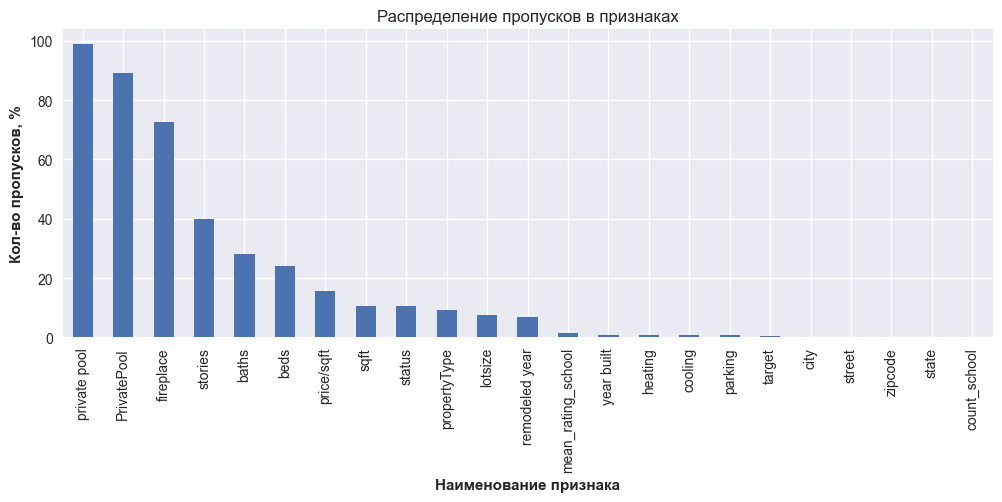

In [246]:
# визуализация пропущенных значений в признаках
col_null.plot(
    kind='bar',
    figsize=(12, 4),
    title='Распределение пропусков в признаках',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Кол-во пропусков, %", fontweight="bold");

Более 70% пропусков содержится в столбцах:
 - private pool (наличие бассейна)
 - PrivatePool (наличие бассейна)
 - fireplace (наличие камина)

Почти 40% пропущенных значений в признаке stories (количество этажей).
Остальные признаки содержат менее 30% пропущенных значений. zipcode, state, count_school не имеют пропусков

## 2. Обработка признаков

In [247]:
# функция для извлечения из строки численных значений у некоторых признаков 
def find_number_in_string(string):
    string = newvalues(string)
    number = re.search(r"\d+", string)
    if number is not None:
        return number.group()
    return np.nan
# функция для замены некоторых значений в признаках
def newvalues(string):
    for key in new_value:
        if key in string:
            return new_value[key]
    return string

In [248]:
data_copy = data.copy()
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              337267 non-null  object 
 1   private pool        4181 non-null    object 
 2   propertyType        342452 non-null  object 
 3   street              377183 non-null  object 
 4   baths               270847 non-null  object 
 5   fireplace           103114 non-null  object 
 6   city                377151 non-null  object 
 7   sqft                336608 non-null  object 
 8   zipcode             377185 non-null  object 
 9   beds                285903 non-null  object 
 10  state               377185 non-null  object 
 11  stories             226469 non-null  object 
 12  PrivatePool         40311 non-null   object 
 13  target              374704 non-null  object 
 14  year built          373572 non-null  object 
 15  remodeled year      350616 non-nul

#### Признак status

In [249]:
# приводим к нижнему регистру
data_copy.status = data_copy.status.str.lower()

In [250]:
print(f'Количество уникальных  значений:  {data_copy.status.nunique()}')

Количество уникальных  значений:  152


In [251]:
print(f'25 популярных значений {data_copy.status.value_counts().head(25)}')

25 популярных значений status
for sale                             199571
active                               105207
foreclosure                            6769
new construction                       5475
pending                                4807
pre-foreclosure                        2119
pre-foreclosure / auction              1560
p                                      1488
under contract show                    1183
 / auction                              936
under contract   showing                793
active under contract                   718
under contract                          692
new                                     690
contingent                              581
price change                            563
auction                                 536
foreclosed                              459
a active                                443
for rent                                398
recently sold                           287
under contract backups                  252
co

In [252]:
print(f'25 непопулярных значений {data_copy.status.value_counts().tail(25)}')

25 непопулярных значений status
coming soon: nov 25.         1
conting accpt backups        1
coming soon: oct 21.         1
pending take backups         1
contingent   no show         1
coming soon: nov 23.         1
pending bring backup         1
pending, continue to show    1
coming soon: nov 14.         1
coming soon: oct 24.         1
coming soon: dec 25.         1
coming soon: nov 11.         1
temporary active             1
coming soon: nov 17.         1
pending w/escape clause      1
coming soon: nov 26.         1
contract                     1
coming soon: dec 27.         1
conditional contract         1
coming soon: nov 8.          1
coming soon: oct 29.         1
coming soon: dec 15.         1
pending w/backup wanted      1
pending backups wanted       1
coming soon: dec 23.         1
Name: count, dtype: int64


In [253]:
# Переименовываем некоторые статусы к   ключевым словам
newvalues_status = {
    'for sale': 'active',
    'back on market': 'active',
    'p': 'pending',
    'pi': 'pending',
    'c continue show': 'active',
    'uc continue to show': 'active'
    }
# заменяем значения статусов ключевыми словами
data_copy.status = data_copy.status.replace(newvalues_status)

In [254]:
# Объеденяем статусы по ключевым словам
new_value = {
    'contingent': 'contingent',
    'pending': 'pending',
    'auction': 'auction',
    'foreclos': 'foreclosure',
    'active': 'active',
    'contract': 'contract',
    'new': 'new construction',
    'sold': 'sold',
    'coming': 'coming soon'
}
# заменяем значения статусов ключевыми словами, 
data_copy.status = data_copy.status.astype(str)
data_copy.status = data_copy.status.apply(newvalues)
data_copy.status = data_copy.status.apply(lambda x: np.nan if x == 'nan' else x)

In [255]:
# Определяем менее популярные, пусть это будет статусы,  количество  которых будет   меньше 200 
# и заменяем их на значение other
other = data_copy.status.value_counts()[data_copy.status.value_counts() < 200]
data_copy.status = data_copy.status.apply(lambda x: 'other' if x in other.index else x)
data_copy.status.value_counts()


status
active              306197
foreclosure           9347
pending               6888
new construction      6165
auction               3070
contract              3050
contingent            1026
price change           563
for rent               398
sold                   289
other                  274
Name: count, dtype: int64

#### Признаки PrivatePool и private pool

In [256]:
# Уникальные значения для признаков PrivatePool и private pool
print(data_copy['PrivatePool'].unique())
print(data_copy['private pool'].unique())

[nan 'yes' 'Yes']
[nan 'Yes']


Кроме пропусков в признаках имеются значения: Yes, yes.  
Можно предположить, что пропущенное значение равнозначно отсутствию бассейна.  
Признаки можно объединить в один и сделать бинарным.

In [257]:
# присвоим значение 1, если есть бассейн, в противном случае 0
data_copy['PrivatePool'] = data_copy['PrivatePool'].apply(lambda x: 1 if x=='Yes' or x=='yes' else 0)
data_copy['private pool'] = data_copy['private pool'].apply(lambda x: 1 if x=='Yes' else 0)

In [258]:
# объединяем признаки PrivatePool и private pool в один признак pool
data_copy['pool'] = data_copy['PrivatePool'] + data_copy['private pool']
# удалим признаки PrivatePool, private pool
data_copy.drop(['PrivatePool', 'private pool'], axis=1, inplace=True)
data_copy['pool'].value_counts()

pool
0    332693
1     44492
Name: count, dtype: int64

#### Признак propertyType

In [259]:
# приводим к нижнему регистру
data_copy.propertyType = data_copy.propertyType.str.lower()

In [260]:
print(f'Количество уникальных  значений:  {data_copy.propertyType.nunique()}\n')

Количество уникальных  значений:  1272



In [261]:
print(f'25 популярных значений {data_copy.propertyType.value_counts().head(25)}')

25 популярных значений propertyType
single-family home               92206
single family                    62869
condo                            42529
single family home               31728
lot/land                         20552
townhouse                        18400
land                             10934
multi-family                      7921
condo/townhome/row home/co-op     7701
traditional                       5913
coop                              3266
multi family                      2794
high rise                         1823
ranch                             1781
mobile/manufactured               1618
detached, one story               1614
single detached, traditional      1581
contemporary                      1557
multi-family home                 1501
1 story                           1235
colonial                          1205
mobile / manufactured             1066
contemporary/modern               1000
apartment                          922
2 stories                   

In [262]:
print(f'25 непопулярных значений {data_copy.propertyType.value_counts().tail(25)}')

25 непопулярных значений propertyType
1 story, historic/older, other (see remarks)                              1
condo/townhome, single detached, other (see remarks), traditional         1
mobile home 1 story                                                       1
dutch, contemporary                                                       1
french, georgian, traditional                                             1
farm/ranch house, single detached, contemporary/modern, ranch             1
a-frame, victorian/federal                                                1
contemporary, modernist, ranch, rustic                                    1
loft, warehouse                                                           1
bungalow, craftsman, ranch, transitional, cottage                         1
30x40 building                                                            1
split-entry, craftsman                                                    1
custom, florida, other, spanish/mediterranean     

In [263]:
# Объеденяем статусы по ключевым словам
new_value = {
    'single': 'single',
    'stor': 'single',
    'detached': 'single',
    'land': 'land',
    'multi': 'multi',
    'mobile': 'mobile',
    'condo': 'condo',
    'coop': 'condo',
    'townhouse': 'condo',
    'co-op': 'condo',
    'contemporary': 'contemporary',
    'ranch': 'ranch',
    'traditional': 'traditional',
    'other': 'other'
}

In [264]:
# преобразовываем
data_copy.propertyType = data_copy.propertyType.astype(str)
data_copy.propertyType = data_copy.propertyType.apply(newvalues)
data_copy.propertyType = data_copy.propertyType.replace([' ', 'nan'], np.nan)

In [265]:
# Определяем менее популярные, пусть это будет типы жилья,  количество  которых будет   меньше 200 
# и заменяем их на значение other
other = data_copy.propertyType.value_counts()[data_copy.propertyType.value_counts() < 200]
data_copy.propertyType = data_copy.propertyType.apply(lambda x: 'other' if x in other.index else x)
data_copy.propertyType.value_counts()

propertyType
single                   198326
condo                     73631
land                      31494
multi                     12513
traditional                6449
other                      3910
mobile                     3488
contemporary               3366
ranch                      2610
high rise                  1823
colonial                   1205
apartment                   922
transitional                560
florida                     530
bungalow                    442
garden home                 305
cape cod                    281
spanish/mediterranean       272
craftsman                   201
Name: count, dtype: int64

#### Признак baths

In [266]:
# приводим к нижнему регистру
data_copy.baths = data_copy.baths.str.lower()
# преобразования данных в  тип данных str
data_copy.baths = data_copy.baths.astype(str)

In [267]:
print(f'25 популярных значений {data_copy.baths.value_counts().head(25)}')

25 популярных значений baths
nan             106338
2 baths          52471
3 baths          35508
2                20452
2.0              16576
4 baths          14764
3.0              10869
3                10113
bathrooms: 2      9538
2.5               8113
bathrooms: 3      6613
1                 6583
1.0               5930
5 baths           5370
4.0               4593
2.5 baths         4486
0                 3811
4                 3567
3.5               3455
bathrooms: 1      3234
2 ba              2686
6 baths           2604
bathrooms: 4      2384
1,500             2209
3 ba              1893
Name: count, dtype: int64


In [268]:
print(f'25 непопулярных значений {data_copy.baths.value_counts().tail(25)}')

25 непопулярных значений baths
3.3 baths             1
2.25 ba               1
34 baths              1
3-1 / 2-2             1
1 / 1 / 1 / 1         1
55.0                  1
25 baths              1
bathrooms: semimod    1
bathrooms: 19         1
76 baths              1
0.5 baths             1
14.5+                 1
4.75 baths            1
29                    1
5.2 baths             1
21 baths              1
5.25 baths            1
116 / 116 / 116       1
41.0                  1
1.8 baths             1
29 baths              1
bathrooms: 21         1
35                    1
bathrooms: 27         1
44.0                  1
Name: count, dtype: int64


In [269]:
new_value = {
    'bathrooms: semimod': '1' 
}

data_copy.baths = data_copy.baths.apply(find_number_in_string)
# приведем к типу float
data_copy.baths = data_copy.baths.astype(float)

In [270]:
data_copy.baths.value_counts()

baths
2.0      119820
3.0       72873
4.0       27899
1.0       25202
5.0        9977
6.0        4497
0.0        3918
7.0        2162
8.0        1190
9.0         552
10.0        342
750.0       237
11.0        190
12.0        138
13.0         74
16.0         52
14.0         46
18.0         32
15.0         28
24.0         17
20.0         16
22.0         10
17.0         10
26.0          8
23.0          8
30.0          6
27.0          5
40.0          4
21.0          4
36.0          3
44.0          3
19.0          3
32.0          3
29.0          2
34.0          2
28.0          2
60.0          1
39.0          1
64.0          1
42.0          1
43.0          1
41.0          1
25.0          1
55.0          1
241.0         1
76.0          1
116.0         1
35.0          1
68.0          1
Name: count, dtype: int64

#### Признак fireplace

In [271]:
# приводим к нижнему регистру
data_copy.fireplace = data_copy.fireplace.str.lower()

In [272]:
print(f'25 популярных значений {data_copy.fireplace.value_counts().head(25)}')

25 популярных значений fireplace
yes                          71212
1                            14544
2                             2432
not applicable                1993
fireplace                      847
3                              564
living room                    433
location                       399
wood burning                   311
gas/gas logs                   300
no                             289
fireplace yn                   287
special features               279
1 fireplace                    274
0                              271
familyrm                       246
fireplace features             239
great room                     207
wood                           206
gas logs, great room           188
ceiling fan                    186
living room, wood burning      185
4                              184
family room, wood burning      149
familyrm, gas logs             146
Name: count, dtype: int64


In [273]:
print(f'25 непопулярных значений {data_copy.fireplace.value_counts().tail(25)}')

25 непопулярных значений fireplace
brick, wood burning                                                                                1
fire sprinkler system                                                                              1
elevator, fire sprinkler system, redecorated, smthr, utility connection, walk-in closets           1
2 fireplace, fireplace master bdr                                                                  1
den, familyrm, great room                                                                          1
central vacuum, elevator, walk-in closets, wet bar                                                 1
den, kitchen                                                                                       1
extra closets, in-law quarters                                                                     1
in den, gas logs, in living room                                                                   1
redecorated, walk-in closets                            

В признаке содержится текстовое описание места установки камина, его свойства, а также количество.  
Сделаем этот признак бинарным с указанием наличия 1 или отсутствия 0 камина.  
Пропущенные значения приравняем к отсутствию камина.  

In [274]:
# определение наличие камина
def presence_fireplace(string):
    if 'no' in str(string):
        return 0
    if '0' in str(string):
        return 0
    if 'n/k' in str(string):
        return 0
    else:  
        return 1
data_copy.fireplace = data_copy.fireplace.apply(presence_fireplace)

# пропущенные значения заполняем 0
data_copy.fireplace.fillna(0, inplace=True)

data_copy.fireplace.value_counts()        

fireplace
1    374520
0      2665
Name: count, dtype: int64

#### Признак city

In [275]:
# к нижнему регистру
data_copy.city = data_copy.city.str.lower()

In [276]:
# заменим неявные пропуски на nan
data_copy.city = data_copy.city.replace([' ', '--'], np.nan)
# кол-во пропусков
data_copy.city.isnull().sum()

68

Мы имеем пропущенные значения в признаке city, восстановим значения используя признак zipcode (почтовый индекс)

In [277]:
# выведем на экран несколько строк с пропущенными значениями в признаке city
data_copy[data_copy.city.isnull()].head()

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
7830,active,single,13155 W Highway 316,2.0,1,NaN,1016,32686,1,FL,...,2000,,Central Heat,"Ceiling Fans, Central Cooling",Covered Parking,None,"$1,471",3.8,0,0
11761,active,NaN,MLS #: HARL16177,NaN,1,NaN,NaN,10037,NaN,NY,...,,,,,,—,None,1.7,0,0
12018,NaN,NaN,488 4th Ave #1,NaN,1,NaN,NaN,11215,NaN,NY,...,,,,,,—,None,6.0,0,0
15234,NaN,condo,8763 Worldquest Blvd # 5504,3.0,1,NaN,"1,450",32821,3,FL,...,2007,None,Forced air,Central,2 spaces,None,$108,4.7,0,1
21529,active,land,SE 117th Ter,NaN,1,NaN,0,32668,NaN,FL,...,,,,,,428195,None,NaN,0,0


In [278]:
# в качестве примера посмотрим записи с почтовым индексом 32686
data_copy[data_copy.zipcode ==  '32686'].head()

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
552,active,single,4550 NW 160th St,2.0,1,reddick,3056,32686,3,FL,...,1964,,Central Electric,Central Electric,,64904,$36,3.7,0,0
790,active,land,14735 NW 111th Ct,NaN,1,reddick,0,32686,NaN,FL,...,1997,,,,,435600,None,3.3,0,0
7830,active,single,13155 W Highway 316,2.0,1,NaN,1016,32686,1,FL,...,2000,,Central Heat,"Ceiling Fans, Central Cooling",Covered Parking,None,"$1,471",3.8,0,0
8476,active,ranch,11500 NW 167th Pl,3.0,1,reddick,2804,32686,4,FL,...,2005,,"Central, Electric",Central Air,,435600,$107,3.7,0,0
11194,active,land,NW 125th St,NaN,1,reddick,0,32686,NaN,FL,...,,,,,,2028589,None,3.3,0,0


Заполним пропуски в city названиями городов, которые принадлежат соответствующим почтовым идексам

In [279]:
# заполняем пропуски по индексу
data_copy['city'] = data_copy.groupby(['zipcode'])['city'].bfill().ffill()
data_copy.city.nunique()

1907

In [280]:
# кол-во пропусков
data_copy.city.isnull().sum()

0

#### Признак sqft

In [281]:
# преобразования данных в  тип данных str
data_copy.sqft = data_copy.sqft.astype(str)

In [282]:
print(f'25 популярных значений {data_copy.sqft.value_counts().head(25)}')

25 популярных значений sqft
nan           40577
0             11854
1,200 sqft      839
1,000 sqft      654
1,100 sqft      573
1,800 sqft      563
1,500 sqft      547
--              535
2,000 sqft      523
1,400 sqft      517
1,600 sqft      455
800 sqft        454
1,300 sqft      410
900 sqft        409
1,440 sqft      378
2,400 sqft      375
960 sqft        362
2,200 sqft      359
1,200           357
3,000 sqft      343
2,100 sqft      326
1,152 sqft      311
1,120 sqft      307
1,700 sqft      301
1,500           299
Name: count, dtype: int64


In [283]:
print(f'25 непопулярных значений {data_copy.sqft.value_counts().tail(25)}')

25 непопулярных значений sqft
8,155 sqft                                 1
20,518 sqft                                1
Total interior livable area: 5,873 sqft    1
7,126 sqft                                 1
Total interior livable area: 6,178 sqft    1
469                                        1
11170                                      1
16,134                                     1
Total interior livable area: 4,559 sqft    1
3,767                                      1
4780                                       1
20816                                      1
13,418                                     1
8,074 sqft                                 1
7,456 sqft                                 1
8452                                       1
19,180 sqft                                1
Total interior livable area: 5,765 sqft    1
8,635 sqft                                 1
11,491                                     1
9,914                                      1
Total interior livable ar

Извлечем числовое значение площади

In [284]:
data_copy.sqft = data_copy.sqft.apply(lambda x: "".join(filter(str.isdigit, x)))
data_copy.loc[data_copy.sqft.isin(['', '0']), 'sqft'] = np.nan
data_copy.sqft = data_copy.sqft.astype(float)

In [285]:
data_copy.sqft.value_counts().head(10)

sqft
1200.0    1426
1000.0    1027
1500.0    1014
1800.0     988
1100.0     938
1400.0     918
2000.0     872
1600.0     835
800.0      755
1300.0     738
Name: count, dtype: int64

#### Признак beds

In [286]:
# к нижнему регистру
data_copy.beds = data_copy.beds.str.lower()

data_copy.beds = data_copy.beds.astype(str)

In [287]:
print(f'25 популярных значений {data_copy.beds.value_counts().head(25)}')

25 популярных значений beds
nan       91282
3 beds    53459
4 beds    35418
3         31406
2 beds    26362
4         20030
2         16110
baths     15282
3 bd      12877
5 beds    11271
4 bd       8265
3.0        8088
5          6424
2 bd       5243
4.0        5231
1          4610
6 beds     3810
5 bd       2633
2.0        2430
6          1806
5.0        1372
0          1230
7 beds     1100
1 bd       1081
-- bd      1013
Name: count, dtype: int64


In [288]:
print(f'25 непопулярных значений {data_copy.beds.value_counts().tail(25)}')

25 непопулярных значений beds
5.11 acres                                                                                                                    1
7,104 sqft                                                                                                                    1
5,654 sqft                                                                                                                    1
1.83 acres                                                                                                                    1
9,365 sqft                                                                                                                    1
5,488 sqft                                                                                                                    1
based on redfin's st johns data, we estimate the home's value is $360,731, which is 2.2% less than its current list price.    1
10.9 acres                                                                

In [289]:
# переносим площади из beds в lotsize
data_copy.loc[data_copy.beds.str.contains('sqft|acr', na=False) == True, 'lotsize'] = data_copy.beds
# заменяем значения площади в признаке beds на nan
new_value = {
    'sqft': 'sqft',
    'acr': 'acr',
    '-- bd': '0'
}
data_copy.beds = data_copy.beds.apply(find_number_in_string)

In [290]:
# приведем к типу float
data_copy.beds = data_copy.beds.astype(float)
data_copy.beds.value_counts().head()

beds
3.0    105832
4.0     68944
2.0     50146
5.0     21700
6.0      6583
Name: count, dtype: int64

#### Признак state

In [291]:
data_copy.state.nunique()

39

In [292]:
print(f'25 популярных значений {data_copy.state.value_counts().head(25)}')

25 популярных значений state
FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
GA      6705
CO      6404
PA      5561
MI      5161
DC      4674
AZ      3347
IN      3328
OR      2789
MA      1516
UT      1325
MD      1090
VT       868
MO       866
VA       801
WI       452
Name: count, dtype: int64


In [293]:
print(f'25 непопулярных значений {data_copy.state.value_counts().tail(25)}')

25 непопулярных значений state
DC    4674
AZ    3347
IN    3328
OR    2789
MA    1516
UT    1325
MD    1090
VT     868
MO     866
VA     801
WI     452
NJ     436
ME     259
IA     242
KY      90
OK      49
MS      40
SC      28
MT       7
DE       5
Fl       1
BA       1
AL       1
OT       1
OS       1
Name: count, dtype: int64


Выполним удаление несуществующих штатов

In [294]:
data_copy = data_copy[(data_copy.state != 'OT') & (data_copy.state != 'OS') & (data_copy.state != 'Fl') & (data_copy.state != 'BA')]
print(data_copy.state.nunique())

35


#### Признак stories

In [295]:
# приведем к нижнему регистру
data_copy.stories = data_copy.stories.str.lower()
data_copy.stories = data_copy.stories.astype(str)

In [296]:
print(f'25 популярных значений {data_copy.stories.value_counts().head(25)}')

25 популярных значений stories
nan              150712
1.0               67454
2.0               55283
1                 23086
2                 18146
3.0               11275
0.0                7241
one                5758
0                  4273
3                  4228
9.0                2918
2.00               2777
two                2495
4.0                2137
2 story            1970
1 story            1253
1.00               1202
4                   892
3+                  868
6.0                 718
1.50                650
5.0                 616
three or more       569
3.00                517
9                   468
Name: count, dtype: int64


In [297]:
print(f'25 непопулярных значений {data_copy.stories.value_counts().tail(25)}')

25 непопулярных значений stories
split entry (bi-level)                        1
co-op                                         1
1 1/2 story                                   1
log home                                      1
1.70                                          1
95                                            1
77                                            1
3 level, site built, split level              1
apartments                                    1
hillside                                      1
82                                            1
2 story, multi level                          1
tudor                                         1
a frame                                       1
quad level                                    1
2 story or 2 level                            1
sixplex                                       1
townhouse-2 story, t3-townhouse 3+ stories    1
multi-level, new englander                    1
4.0000                                        1
1.2    

In [298]:
new_value = {
    'one': '1',
    'two': '2',
    'bi-level': '2',
    'three': '3',
    'tri': '3',
    'quad': '4'
}

In [299]:
data_copy.stories = data_copy.stories.apply(find_number_in_string)
# приведем к типу float
data_copy.stories = data_copy.stories.astype(float)

In [300]:
data_copy.stories.value_counts().head(25)

stories
1.0     101586
2.0      82225
3.0      17900
0.0      11514
9.0       3386
4.0       3120
6.0       1012
5.0        808
7.0        405
8.0        335
12.0       151
16.0       119
11.0       114
20.0       105
14.0        94
15.0        89
17.0        87
13.0        81
10.0        75
21.0        73
19.0        69
18.0        59
23.0        51
25.0        46
24.0        43
Name: count, dtype: int64

#### Признак price/sqft

In [301]:

data_copy['price/sqft'] = data_copy['price/sqft'].astype(str)

data_copy['price/sqft'] = data_copy['price/sqft'].apply(lambda x: "".join(filter(str.isdigit, x)))
data_copy.loc[data_copy['price/sqft'] == '', 'price/sqft'] = np.nan
data_copy['price/sqft'] = data_copy['price/sqft'].astype(float)


In [302]:
data_copy['price/sqft'].value_counts().head(10)

price/sqft
125.0    1722
121.0    1710
128.0    1708
123.0    1702
127.0    1697
132.0    1688
122.0    1686
130.0    1684
118.0    1675
133.0    1674
Name: count, dtype: int64

#### Признак target

In [303]:
print(f'Количество уникальных  значений:  {data_copy.target.nunique()}\n')

Количество уникальных  значений:  43939



In [304]:
print(f'25 популярных значений {data_copy.target.value_counts().head(25)}')

25 популярных значений target
$225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
$375,000    1163
$450,000    1141
$499,000    1099
$175,000    1096
$425,000    1075
$599,000    1012
$265,000     992
$235,000     975
$150,000     973
$399,900     963
$285,000     952
$699,000     951
$1,000       947
$215,000     947
$185,000     937
Name: count, dtype: int64


In [305]:
print(f'25 непопулярных значений {data_copy.target.value_counts().tail(25)}')

25 непопулярных значений target
$215,759      1
1,194,900     1
$888,515      1
279,095       1
$481,680      1
$814,772      1
$234,001      1
$451,087      1
$439,899      1
$199,000+     1
$124,422      1
$645,000+     1
67,400        1
$409,841      1
$523,310      1
22,350        1
2,042,572     1
425,186       1
$620,490+     1
$2,284,000    1
$390,359      1
$458,900+     1
274,359       1
$273,490+     1
$171,306      1
Name: count, dtype: int64


In [306]:
# единственное значение с диапазоном цен
print('До замены:', data_copy.loc[330468, 'target'])
# заменим его на среднее значение из диапазона
data_copy.loc[330468, 'target'] = '1326'
print('После замены:', data_copy.loc[330468, 'target'])

До замены: $1,215 - $1,437/mo
После замены: 1326


In [307]:
data_copy.target = data_copy.target.astype(str)

data_copy.target = data_copy.target.apply(lambda x: "".join(filter(str.isdigit, x)))
data_copy.loc[data_copy.target == '', 'target'] = np.nan
data_copy.target = data_copy.target.astype(float)

In [308]:
data_copy.target.value_counts().head(10)

target
225000.0    1805
275000.0    1650
250000.0    1644
350000.0    1641
325000.0    1562
399000.0    1547
299900.0    1534
249900.0    1500
299000.0    1452
375000.0    1442
Name: count, dtype: int64

#### Признак year built

In [309]:
# уникальные значения
data_copy['year built'].unique()

array(['2019', '1961', '2006', '', '1920', '1976', '1970', '1965', '2015',
       '1996', '1982', '1905', '2008', '1899', '2016', '1954', '1989',
       '2014', '1915', '1994', '1910', '1923', '1960', '1977', '1972',
       '1963', '1981', '1949', '1930', '1991', '1958', '2005', '2017',
       '2018', '1983', '1928', '1998', '1997', '1964', '1974', '1940',
       '1973', '1968', '1999', '1918', '2007', '1984', '1946', '2003',
       '2000', '2004', '1969', '2002', '1952', '1947', '1957', '1978',
       '1956', '1967', '1975', '1988', '1955', '1950', '1959', '2012',
       '1924', '1966', '1992', '2001', '1995', '1985', '2010', '1971',
       '1909', '1953', '1993', '1990', '1980', '1951', '1907', '1885',
       '1941', '1927', '1929', '1901', None, '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1900', '1895', '1911', '1948', '1942', '1916', '1931',
 

In [310]:
# неявные пропуски меняем на nan
data_copy['year built'] = data_copy['year built'].replace(['No Data', '', '1'], np.nan)
data_copy['year built'] = data_copy['year built'].astype(str)

In [311]:
new_value = {
    '559990649990': '2021',
    '1057': '1957',
    '1060': '1960',
    '1208': '1908',
    '1019': '1919',
    '2025': '2021'
}

In [312]:
data_copy['year built'] = data_copy['year built'].apply(find_number_in_string)
# преобразуем в формат float
data_copy['year built'] = data_copy['year built'].astype(float)

#### Признак remodeled year

In [313]:
data_copy['remodeled year'].unique()

array(['', '1967', '2006', None, '2015', '1997', '2019', '1982', '1905',
       '2009', '2007', '1996', '1995', '1988', '1972', '1949', '1954',
       '1930', '2003', '2000', '1994', '2005', '1983', '1965', '1968',
       '1993', '1999', '2014', '2008', '2010', '2004', '2002', '1984',
       '1952', '1978', '1975', '1971', '1947', '1957', '1950', '2012',
       '1973', '1970', '2016', '1989', '1998', '1980', '1986', '1955',
       '1991', '2011', '2017', '1941', '2001', '1990', '1979', '1901',
       '1918', '1977', '1962', '1956', '2013', '1960', '1981', '1969',
       '1987', '1958', '1910', '1925', '1964', '1966', '1992', '1943',
       '1961', '1948', '1931', '1976', '1974', '1935', '1940', '2018',
       '1916', '1914', '1963', '1985', '1951', '1944', '1942', '1959',
       '1927', '1946', '1945', '1920', '1938', '1936', '0', '1939',
       '1915', '1928', '1923', '1929', '1898', '1899', '1934', '1953',
       '1926', '1937', '1912', '1917', '1906', '1932', '1919', '1921',
       

In [314]:
# неявные пропуски меняем на nan
data_copy['remodeled year'] = data_copy['remodeled year'].replace(['', '0', '1111'], np.nan)
# меняем тип данных на float
data_copy['remodeled year'] = data_copy['remodeled year'].astype(float)

#### Признак heating

In [315]:
# приведем к нижнему регистру
data_copy.heating = data_copy.heating.str.lower()
data_copy.heating = data_copy.heating.astype(str)
print(f'Количество уникальных  значений:  {data_copy.heating.nunique()}')

Количество уникальных  значений:  1919


In [316]:
print(f'25 популярных значений {data_copy.heating.value_counts().head(25)}')

25 популярных значений heating
forced air                     134313
                               105795
other                           29623
electric                        10217
gas                              9299
heat pump                        8851
no data                          8611
central air                      7814
central electric                 7112
central                          6247
central, electric                4253
baseboard                        3815
None                             3533
wall                             3301
electric heat                    3064
heating system                   2709
forced air, heat pump            1767
radiant                          1485
central air, ceiling fan(s)      1432
natural gas heat                 1383
central furnace                  1036
forced air, gas                   962
central electric, zoned           873
forced air heating                810
, gas hot air/furnace             776
Name: count, dtype:

In [317]:
print(f'25 непопулярных значений {data_copy.heating.value_counts().tail(25)}')

25 непопулярных значений heating
window/wall unit                                                               1
gravity, natural gas                                                           1
gas bottled, wood                                                              1
baseboard, radiant floor, wood boiler                                          1
above ground tank, steam/radiators, wood stove, wall heaters, oil/hot water    1
electric, hot water                                                            1
wood stove                                                                     1
central, exhaust fans, natural gas, zoned                                      1
g-fresh air ventilation, gas hot air/furnace                                   1
electric heating, gas heating                                                  1
, g-energy star hvac, gas hot air/furnace, multizone heat                      1
propane/hot air                                                             

In [318]:
new_value = {
    'electric': 'electric',
    'air': 'air',
    'central': 'central',
    'gas': 'gas',
    'pump': 'pump',
    'baseboard': 'baseboard',
    'wall': 'wall',
    'radiant': 'radiant',
    'furnance':'furnance',
    'refrigeration': 'refrigeration',
    'other': 'other',
    'heating': 'other',
    'hot water': 'hot water'
}

In [319]:
data_copy.heating = data_copy.heating.apply(newvalues)
data_copy.heating = data_copy.heating.replace(['', 'no data', 'nan', 'None'], np.nan)

In [320]:
# Определяем менее популярные, пусть это будет типы отопления,  количество  которых будет   меньше 200 
# и заменяем их на значение other
other = data_copy.heating.value_counts()[data_copy.heating.value_counts() < 200]
data_copy.heating = data_copy.heating.apply(lambda x: 'other' if x in other.index else x)

In [321]:
data_copy.heating.value_counts()

heating
air              152919
other             34072
electric          29208
gas               12407
central           10116
pump               9859
baseboard          4175
wall               3916
radiant            1549
refrigeration       585
hot water           219
oil                 217
Name: count, dtype: int64

#### Признак cooling

In [322]:
# приведем к нижнему регистру
data_copy.cooling = data_copy.cooling.str.lower()
data_copy.cooling = data_copy.cooling.astype(str)
print(f'Количество уникальных  значений:  {data_copy.cooling.nunique()}')

Количество уникальных  значений:  1439


In [323]:
print(f'25 популярных значений {data_copy.cooling.value_counts().head(25)}')

25 популярных значений cooling
central                                            158754
                                                   120430
central air                                         14384
no data                                             10616
has cooling                                          9730
none                                                 7390
central electric                                     6154
wall                                                 4018
central gas                                          3573
None                                                 3533
central heating                                      2807
cooling system                                       2700
central a/c                                          2051
other                                                1840
central a/c (electric), central heat (gas)           1646
central a/c (electric), central heat (electric)      1429
refrigeration                            

In [324]:
print(f'25 непопулярных значений {data_copy.cooling.value_counts().tail(25)}')

25 непопулярных значений cooling
central air conditioning, whole house fan                                                                         1
3+ units, other heating (see remarks)                                                                             1
energy star cooling system, central a/c, zoned cooling                                                            1
panel/floor/wall, space heater                                                                                    1
baseboard, hot water, stove                                                                                       1
baseboard, stove - pellet                                                                                         1
central electric, window units, wall units                                                                        1
central air, oil floor furnace                                                                                    1
g-energy star hvac, g-fresh air ventila

In [325]:
new_value = {
    'electric': 'electric',
    'air': 'air',
    'gas': 'gas',
    'cooling': 'cooling',
    'wall': 'wall',
    'refrigeration': 'refrigeration',
    'pump': 'pump',
    'other': 'other',
    'heating': 'other',
    'hot water': 'hot water',
    'central': 'central',
    'window': 'window'
}

In [326]:
data_copy.cooling = data_copy.cooling.apply(newvalues)
data_copy.cooling = data_copy.cooling.replace(['', 'no data', 'nan', 'None', 'none'], np.nan)

In [327]:
# Определяем менее популярные, пусть это будет типы системы охлаждения,  количество  которых будет   меньше 200 
# и заменяем их на значение other
other = data_copy.cooling.value_counts()[data_copy.cooling.value_counts() < 200]
data_copy.cooling = data_copy.cooling.apply(lambda x: 'other' if x in other.index else x)

In [328]:
data_copy.cooling.value_counts().head(25)

cooling
central          161543
air               20683
electric          15528
cooling           13267
other              8134
wall               5596
gas                4902
refrigeration      2745
pump               1339
evaporative        1011
window              464
Name: count, dtype: int64

#### Признак parking

In [329]:
# приведем к нижнему регистру
data_copy.parking = data_copy.parking.str.lower()
print(f'Количество уникальных  значений:  {data_copy.parking.nunique()}')

Количество уникальных  значений:  3320


In [330]:
print(f'25 популярных значений {data_copy.parking.value_counts().head(25)}')

25 популярных значений parking
                                    171883
attached garage                      70752
2 spaces                             28063
1 space                              14252
no data                              13334
detached garage                      13201
carport                               7743
off street                            5279
3 spaces                              4724
carport, attached garage              3025
1                                     2936
4 spaces                              2917
2                                     2756
none                                  2369
on street                             1707
attached garage, detached garage      1354
0                                     1114
attached garage, carport               993
parking desc                           900
6 spaces                               755
detached garage, attached garage       726
driveway                               693
5 spaces               

In [331]:
print(f'25 непопулярных значений {data_copy.parking.value_counts().tail(25)}')

25 непопулярных значений parking
deed restrictions, fishing, no truck/rv/motorcycle parking, pool, sidewalk, water access, waterfront                                                                                      1
electric door opener, rv gate, rv parking, gated parking, rv garage, slab parking spaces                                                                                                  1
electric door opener, extnded lngth garage, separate strge area, gated parking, slab parking spaces                                                                                       1
electric door opener, tandem garage, rv gate, dir entry frm garage, slab parking spaces                                                                                                   1
asphalt drive, circular drive, parking pad                                                                                                                                                1
boat, garage door opener, o

In [332]:
# пропуски и отсутствие гаража меняем на nan
data_copy.parking = data_copy.parking.replace(['0', '', 'no', 'no data', 'no garage', 'none'], np.nan)

Сделаем признак бинарным: при наличии парковки/гаража ставим значение 1, в противном случае 0.

In [333]:
data_copy.parking = np.where(data_copy.parking.isnull(), 0, 1)

In [334]:
data_copy.parking.value_counts()

parking
0    192256
1    184925
Name: count, dtype: int64

#### Признак lotsize

Содержит данные о площади участка.   
Единицы измерения: акры (acres) и квадратные футы (sqft)

In [335]:
# приводим к нижнему регистру
data_copy.lotsize = data_copy.lotsize.str.lower()
# преобразования данных в  тип данных str
data_copy.lotsize = data_copy.lotsize.astype(str)

In [336]:
print(f'25 популярных значений {data_copy.lotsize.value_counts().head(25)}')

25 популярных значений lotsize
               33004
None           25412
—              25247
no data         5330
-- sqft lot     3819
0.26 acres      3172
0.25 acres      2741
0.28 acres      2656
0.27 acres      2503
0.29 acres      2382
0.34 acres      1993
0.31 acres      1737
0.32 acres      1601
6,098 sqft      1546
0.3 acres       1468
0.33 acres      1431
1 acre          1397
0.35 acres      1376
7,405 sqft      1376
0.46 acres      1309
6,534 sqft      1301
4,356 sqft      1279
10,000 sqft     1260
0.36 acres      1240
5,000 sqft      1209
Name: count, dtype: int64


In [337]:
print(f'25 непопулярных значений {data_copy.lotsize.value_counts().tail(25)}')

25 непопулярных значений lotsize
187284            1
8815              1
5,509 sq. ft.     1
36962             1
5752              1
23.08 acres       1
7,397 sqft lot    1
21523             1
15425             1
628571            1
10,242 sq. ft.    1
96093             1
5,695 sq. ft.     1
9,212 sqft lot    1
9,657 sqft lot    1
9,537 sq. ft.     1
407 sqft          1
29873             1
88027             1
3140              1
14575             1
113169            1
4,786 sqft        1
17570             1
7,084 sqft lot    1
Name: count, dtype: int64


Площадь в акрах представалена числом с плавающей точкой, а в квадратных футах - числом с разделителем групп разрядов в виде запятой. Приведем все значения к одной единице измерения - sqft.
1 акр = 43560 квадратныx футов

In [338]:
#  Функция для поиска в строке значение площади в акрах(могут быть как сплавающей точкой так и без неё)
def acres(string):
    pattern = r"[-+]?\d+\.\d+"
    acr = re.search(pattern, string)
    if acr:
        return float(acr.group())
    pattern = r"[-+]?\d+"
    acr = re.search(pattern, string)
    if acr:
        return float(acr.group())
    return string
# Функция преобразования пдощади в квадратные футы, если нет никаких данных то возвращает np.nan  
def convert_acres(string):
    if '--' in string:
        return np.nan
    elif 'sq' in string:
        return "".join(filter(str.isdigit, string))
    elif 'acr' in string:
        if isinstance(acres(string), float):
            return acres(string) * 43560
        else:
            return np.nan
    elif string.isdigit():
        return string
    else: 
        return np.nan 

In [339]:
data_copy.lotsize = data_copy.lotsize.apply(convert_acres)


In [340]:
data_copy.lotsize = round(data_copy.lotsize.astype(float))

In [341]:
data_copy.lotsize.value_counts().head(10)

lotsize
11326.0    3775
10890.0    3517
12197.0    3167
11761.0    2976
12632.0    2829
6098.0     2754
7405.0     2727
10000.0    2708
13068.0    2556
14810.0    2374
Name: count, dtype: int64

## 3.Работа с пропусками, дубликатами и выбросами

In [342]:
# доля пропусков в каждом столбце датасета в процентах после первичной обработки
col_null = data_copy.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100 
col_null

remodeled year        60.017763
stories               40.555961
cooling               37.639090
heating               31.268211
beds                  29.381868
baths                 28.588889
lotsize               24.761589
price/sqft            17.481077
year built            16.860957
sqft                  14.117741
status                10.583136
propertyType           9.240293
mean_rating_school     1.365113
target                 0.657767
street                 0.000530
state                  0.000000
zipcode                0.000000
parking                0.000000
city                   0.000000
fireplace              0.000000
count_school           0.000000
pool                   0.000000
dtype: float64

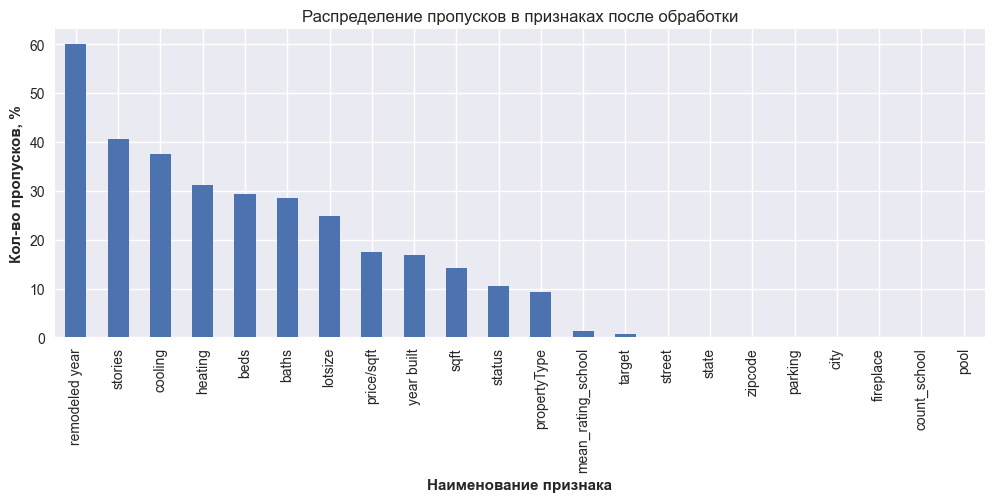

In [343]:
# визуализация пропущенных значений в признаках после обработки
col_null.plot(
    kind='bar',
    figsize=(12, 4),
    title='Распределение пропусков в признаках после обработки',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Кол-во пропусков, %", fontweight="bold");

Признаки с пропусками более 30%:

 - **remodeled year** (год реконструкции)
 - **stories** (количество этажей)
 - **cooling** (тип кондиционирования)
 - **heating** (тип отопления)

####  Удаление дубликатов

In [344]:
# дубликаты
print('Количество дубликатов:', data_copy.duplicated().sum())

Количество дубликатов: 1736


In [345]:
# удалим дублирующиеся записи
data_copy.drop_duplicates(inplace=True)
# сбросим индексы
data_copy.reset_index(drop=True, inplace=True)
data_copy.shape

(375445, 22)

#### Заполнение пропущенных значений

**target** можно получить путем произведения признаков **sqft, price/sqft**. Соответственно мы сможем заполнить некоторые пропуски данных в этих столбцах путем математических вычеслений при условии, что  в двух из трех значения будут заполнены в соответсвующих  строках.   

В первую очередь рассмотрим **target**

In [346]:
# Создаем маску для строк, имеющих пропуски в столбце target.
target_mask = data_copy['target'].isnull()
# Создаем маску для строк, не имеющих пропусков в столбцах price/sqft и sqft.
price_sqft_mask = data_copy[['price/sqft', 'sqft']].notnull().all(axis=1)


In [347]:
# строки, в которых можно заполнить пропуски в целевом признаке
data_copy[target_mask & price_sqft_mask][['target', 'sqft', 'price/sqft']]

,target,sqft,price/sqft
1905,NaN,1016.0,151.0
6566,NaN,1620.0,83.0
6901,NaN,1820.0,210.0
6928,NaN,1032.0,226.0
6930,NaN,975.0,56.0
...,...,...,...
371649,NaN,2089.0,175.0
371689,NaN,2634.0,18.0
373293,NaN,1780.0,53.0
374762,NaN,1082.0,236.0


In [348]:
# Заполняем пропуски в столбце target перемножением значений price/sqft и sqft.
data_copy.loc[target_mask & price_sqft_mask, 'target'] = data_copy.loc[target_mask & price_sqft_mask, 'price/sqft'] * data_copy.loc[target_mask & price_sqft_mask, 'sqft']

**price/sqft**

In [349]:
# Создаем маску для строк, имеющих пропуски в столбце price/sqft.
price_mask = data_copy['price/sqft'].isnull()
# Создаем маску для строк, не имеющих пропусков в столбцах target и sqft.
target_sqft_mask = data_copy[['target', 'sqft']].notnull().all(axis=1)

In [350]:
# строки, в которых можно заполнить пропуски в price/sqft
data_copy[price_mask & target_sqft_mask][['target', 'sqft', 'price/sqft']]

,target,sqft,price/sqft
60,333543.0,2088.0,NaN
90,319000.0,107250.0,NaN
96,493999.0,1790.0,NaN
136,270000.0,109200.0,NaN
161,86960.0,768.0,NaN
...,...,...,...
375286,95701.0,752.0,NaN
375329,110820.0,1200.0,NaN
375331,335000.0,409538.0,NaN
375340,253885.0,2019.0,NaN


In [351]:
# Заполняем пропуски в столбце price/sqft делением значений target на sqft.
data_copy.loc[price_mask & target_sqft_mask, 'price/sqft'] = round(data_copy.loc[price_mask & target_sqft_mask, 'target'] / data_copy.loc[price_mask & target_sqft_mask, 'sqft'])

**sqft**

In [352]:
# Создаем маску для строк, имеющих пропуски в столбце sqft.
sqft_mask = data_copy.sqft.isnull()
# Создаем маску для строк, не имеющих пропусков в столбцах target и sqft.
target_price_mask = data_copy[['target', 'price/sqft']].notnull().all(axis=1)

In [353]:
# строки, в которых можно заполнить пропуски в sqft
data_copy[sqft_mask & target_price_mask][['target', 'sqft', 'price/sqft']]

,target,sqft,price/sqft
7,68000.0,NaN,57.0
374,54995.0,NaN,46.0
458,129900.0,NaN,81.0
1176,28500.0,NaN,24.0
1251,375000.0,NaN,191.0
...,...,...,...
374295,1650.0,NaN,2.0
374778,545000.0,NaN,222.0
374968,59900.0,NaN,50.0
375149,199900.0,NaN,125.0


In [354]:
# Заполняем пропуски в столбце sqft делением значений target на price/sqft.
data_copy.loc[sqft_mask & target_price_mask, 'sqft'] = round(data_copy.loc[sqft_mask & target_price_mask, 'target'] / data_copy.loc[sqft_mask & target_price_mask, 'price/sqft'])

Тип недвижимости *land* подразумевает себя продажу только земли. В некоторых признаках, таких как **fireplace**, **baths** и **beds**, указаны положительные значения. На момент продажи на земельном участке физически дом отсутствует (был разрушен или демонтирован), но информация о нем сохранена.  
Количество ванных комнат и спален, а также наличие камина у недвижимости с типом **land** укажем равное 0.

In [355]:
# Рассмотрим на примере признака baths 
mask_bath = data_copy[['baths']].notnull().all(axis=1)
data_copy[mask_bath][data_copy[mask_bath]['propertyType'] == 'land'].head(10)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
127,active,land,119 Bayshore Dr,2.0,1,cape coral,2493.0,33904,3.0,FL,...,1968.0,1973.0,air,central,1,11761.0,211.0,5.5,2,1
295,pending,land,Goodhope,0.0,1,houston,NaN,77021,NaN,TX,...,NaN,NaN,NaN,NaN,0,4312.0,NaN,2.3,0,0
364,active,land,1449 Tern Ct,0.0,1,poinciana,NaN,34759,NaN,FL,...,NaN,NaN,NaN,NaN,0,15960.0,NaN,2.2,0,0
590,active,land,1211 Molona St,0.0,1,reunion,NaN,34747,NaN,FL,...,NaN,NaN,NaN,NaN,0,7579.0,NaN,5.4,1,0
630,active,land,4719 Rue St,0.0,1,houston,NaN,77033,NaN,TX,...,NaN,NaN,NaN,NaN,0,5600.0,NaN,2.3,0,0
859,active,land,120 Smallwood Rd,0.0,1,rotonda west,NaN,33947,NaN,FL,...,NaN,NaN,NaN,NaN,0,10081.0,NaN,5.7,0,0
999,active,land,9270 Griggs Rd,0.0,1,englewood,NaN,34224,NaN,FL,...,NaN,NaN,NaN,NaN,0,12300.0,NaN,5.7,0,0
1405,active,land,4424 Sturkie Ave,0.0,1,port charlotte,NaN,33953,NaN,FL,...,NaN,NaN,NaN,NaN,0,5000.0,NaN,5.0,0,0
1454,active,land,152 Prineville St,0.0,1,port charlotte,NaN,33954,NaN,FL,...,NaN,NaN,NaN,NaN,0,10001.0,NaN,4.2,0,0
1490,active,land,1970 Kentucky Ave,0.0,1,englewood,NaN,34224,NaN,FL,...,NaN,NaN,NaN,NaN,0,12300.0,NaN,5.7,0,0


In [356]:
# Устанавливаем признакам baths, fireplace и beds значение 0, если признак propertyType равен 'land'.
data_copy.loc[data_copy['propertyType'] == 'land', ['baths', 'fireplace', 'beds']] = 0

In [357]:
# Заполняем пропуски в столбцах year built, mean_rating_school и lotsize медианным значением по zipcode
for col in ['year built', 'mean_rating_school', 'lotsize']:
    data_copy[col].fillna(data_copy.groupby('zipcode')[col].transform('median'), inplace=True)


In [358]:
# Заполняем пропуски в столбцах beds и baths медианным значением по propertyType и city.
for col in ['beds', 'baths']:
    data_copy[col].fillna(data_copy.groupby(['propertyType', 'city'])[col].transform('median'), inplace=True)

In [359]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375445 entries, 0 to 375444
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              335532 non-null  object 
 1   propertyType        340609 non-null  object 
 2   street              375443 non-null  object 
 3   baths               341402 non-null  float64
 4   fireplace           375445 non-null  int64  
 5   city                375445 non-null  object 
 6   sqft                323613 non-null  float64
 7   zipcode             375445 non-null  object 
 8   beds                321524 non-null  float64
 9   state               375445 non-null  object 
 10  stories             222752 non-null  float64
 11  target              373315 non-null  float64
 12  year built          375200 non-null  float64
 13  remodeled year      149849 non-null  float64
 14  heating             257771 non-null  object 
 15  cooling             233867 non-nul

#### Удаление неинформативных и избыточных признаков

In [360]:
#создаем копию 
drop_data = data_copy.copy()

In [361]:
# доля пропусков в процентах
drop_data.isnull().sum().sort_values(ascending=False) / data.shape[0] * 100 

remodeled year        59.810438
stories               40.482257
cooling               37.535427
heating               31.197953
beds                  14.295637
price/sqft            14.182695
sqft                  13.741798
status                10.581810
propertyType           9.235786
baths                  9.025544
target                 0.564710
mean_rating_school     0.198046
lotsize                0.173920
year built             0.064955
street                 0.000530
state                  0.000000
zipcode                0.000000
city                   0.000000
fireplace              0.000000
parking                0.000000
count_school           0.000000
pool                   0.000000
dtype: float64

In [362]:
print(f'Количество уникальных  значений city:  {drop_data.city.nunique()}')
print(f'Количество уникальных  значений zipcode:  {drop_data.zipcode.nunique()}')
print(f'Количество уникальных  значений street:  {drop_data.street.nunique()}')

Количество уникальных  значений city:  1906
Количество уникальных  значений zipcode:  4548
Количество уникальных  значений street:  337072


Удалим признаки у которых количество пропусков более 30%, а также признаки **city**, **zipcode**, **street** т.к. они сгруппированы по названию штата.

In [363]:
# удаляем столбцы с пропусками более 30% и неинформативные признаки
drop_data.drop(['remodeled year', 'stories', 'cooling', 'heating', 'city', 'zipcode', 'street'], axis=1, inplace=True)

In [364]:
# удаляем строки с пропусками
drop_data.dropna(axis=0, inplace=True)
print(drop_data.shape)

(249026, 15)


#### Разведывательный анализ (EDA)

In [365]:
# статистика по числовым признакам
drop_data.describe()

,baths,fireplace,sqft,beds,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
count,249026.000000,249026.000000,249026.0,249026.000000,2.490260e+05,249026.000000,249026.000000,2.490260e+05,2.490260e+05,249026.000000,249026.000000,249026.000000
mean,3.063465,0.980363,inf,4.306006,6.471566e+05,1979.285894,0.611599,4.954712e+04,5.153747e+02,5.121546,0.693369,0.144905
std,17.966765,0.138748,NaN,27.038442,1.784340e+06,34.143140,0.487388,4.400302e+06,2.546534e+04,1.963819,1.156889,0.352005
min,0.000000,0.000000,1.0,0.000000,1.000000e+00,1700.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,0.000000,0.000000
25%,2.000000,1.000000,1310.0,3.000000,2.100000e+05,1956.000000,0.000000,5.000000e+03,1.190000e+02,3.600000,0.000000,0.000000
50%,2.000000,1.000000,1851.0,3.000000,3.389900e+05,1987.000000,1.000000,7.597000e+03,1.730000e+02,5.000000,0.000000,0.000000
75%,3.000000,1.000000,2640.0,4.000000,5.950000e+05,2007.000000,1.000000,1.219700e+04,2.970000e+02,6.500000,1.000000,0.000000
max,750.000000,1.000000,inf,708.000000,1.650000e+08,2022.000000,1.000000,2.147480e+09,5.950000e+06,10.000000,11.000000,1.000000


Первые выводы по выбросам:  
- **baths** максимальное количество 750 вынных(нереально много)
- **sqft**  в значениях max и mean вывело бесконечность
- **beds** 708 спален тоже многовато
- **lotsize** 2147480000 кв. футов это примерно 200 кв.км
- **price/sqft** 5950000 стоимость за кв. фут многовато.

In [366]:
# выведим строки, где sqft приняло значение inf 
display(drop_data[drop_data.sqft == float('inf')])
# удалим её
drop_data.drop(drop_data[drop_data.sqft == float('inf')].index, inplace=True)

,status,propertyType,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
188362,foreclosure,single,2.0,1,inf,5.0,MI,1000.0,1927.0,1,3920.0,0.0,1.5,0,0


In [367]:
# статистика по числовым признакам
drop_data.describe()

,baths,fireplace,sqft,beds,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
count,249025.000000,249025.000000,2.490250e+05,249025.000000,2.490250e+05,249025.000000,249025.000000,2.490250e+05,2.490250e+05,249025.00000,249025.000000,249025.000000
mean,3.063470,0.980363,8.179321e+03,4.306003,6.471592e+05,1979.286104,0.611597,4.954731e+04,5.153768e+02,5.12156,0.693372,0.144905
std,17.966801,0.138748,1.839103e+06,27.038496,1.784343e+06,34.143048,0.487388,4.400311e+06,2.546539e+04,1.96381,1.156890,0.352006
min,0.000000,0.000000,1.000000e+00,0.000000,1.000000e+00,1700.000000,0.000000,0.000000e+00,0.000000e+00,1.00000,0.000000,0.000000
25%,2.000000,1.000000,1.310000e+03,3.000000,2.100000e+05,1956.000000,0.000000,5.000000e+03,1.190000e+02,3.60000,0.000000,0.000000
50%,2.000000,1.000000,1.851000e+03,3.000000,3.389900e+05,1987.000000,1.000000,7.597000e+03,1.730000e+02,5.00000,0.000000,0.000000
75%,3.000000,1.000000,2.640000e+03,4.000000,5.950000e+05,2007.000000,1.000000,1.219700e+04,2.970000e+02,6.50000,1.000000,0.000000
max,750.000000,1.000000,7.959794e+08,708.000000,1.650000e+08,2022.000000,1.000000,2.147480e+09,5.950000e+06,10.00000,11.000000,1.000000


Построим гистограммы и коробчатые диаграммы распределения каждого числового признака

In [368]:
# создадим список с названиями числовых признаков за исключением бинарных и year built
col_num = ['baths', 'sqft', 'beds', 'target', 'lotsize', 'price/sqft']

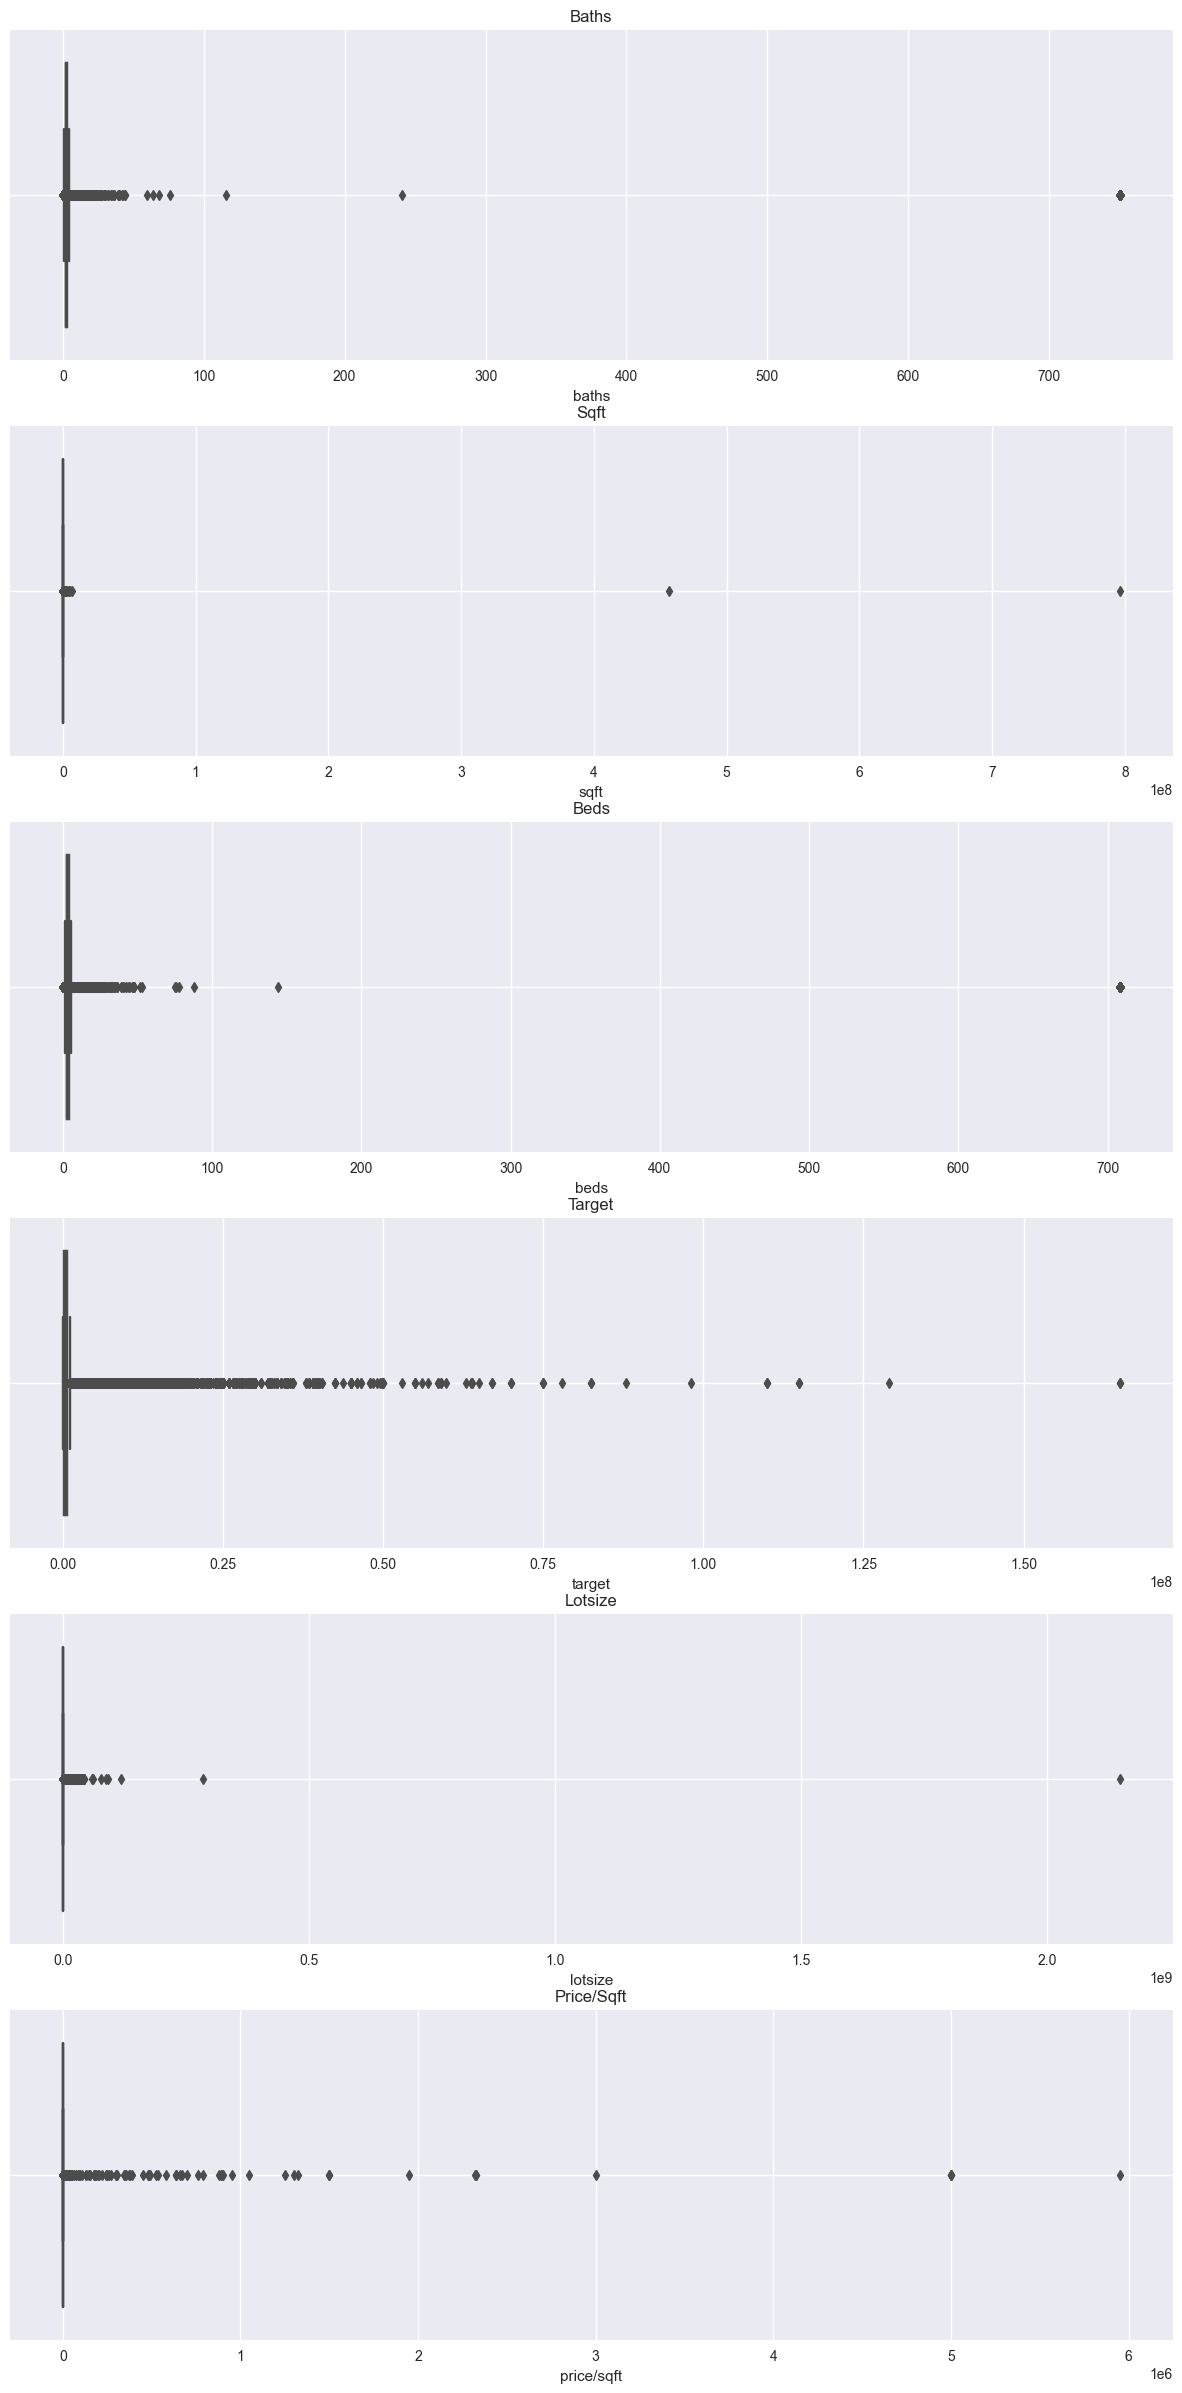

In [369]:
# строим визуализацию
fig, axes = plt.subplots(len(col_num), figsize=(15, 30))
for i, col in enumerate(col_num):
    boxplot = sns.boxplot(data=drop_data, x=col, ax=axes[i])
    boxplot.grid(True)
    boxplot.set_title(f"{col.title()}")

Визуально видно, что выбросы присутствуют в числовых признаках. Перед очисткой изучим целевой признак **target**.

In [370]:
# посмотрим самые дорогие объекты более $100 млн
drop_data[drop_data['target'] > 1e8]

,status,propertyType,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
54132,active,single,24.0,1,38000.0,12.0,CA,110000000.0,2000.0,1,226512.0,2895.0,7.3,1,1
119700,active,single,10.0,1,12201.0,9.0,CA,115000000.0,1936.0,0,431244.0,9425.0,7.3,1,1
143299,active,single,23.0,1,28660.0,20.0,CA,165000000.0,1998.0,1,236531.0,5757.0,7.3,1,1
178575,active,single,23.0,1,43000.0,12.0,CA,129000000.0,2002.0,1,1082902.0,3000.0,7.3,1,1
285005,active,single,23.0,1,28660.0,20.0,CA,165000000.0,1998.0,1,429937.0,5757.0,7.3,1,1
293166,active,single,10.0,1,12201.0,9.0,CA,115000000.0,1936.0,0,168577.0,9425.0,7.3,1,1
352736,active,land,0.0,0,741.0,0.0,CA,110000000.0,2007.0,0,576734.0,148448.0,7.3,1,0


Объекты расположены в штате Калифорния (одним из самых богатых штатов), имеют большую площадь, много ванных комнат и спален, высокий рейтинг школ, бассейны и камины.

Text(0.5, 0, 'Цена')

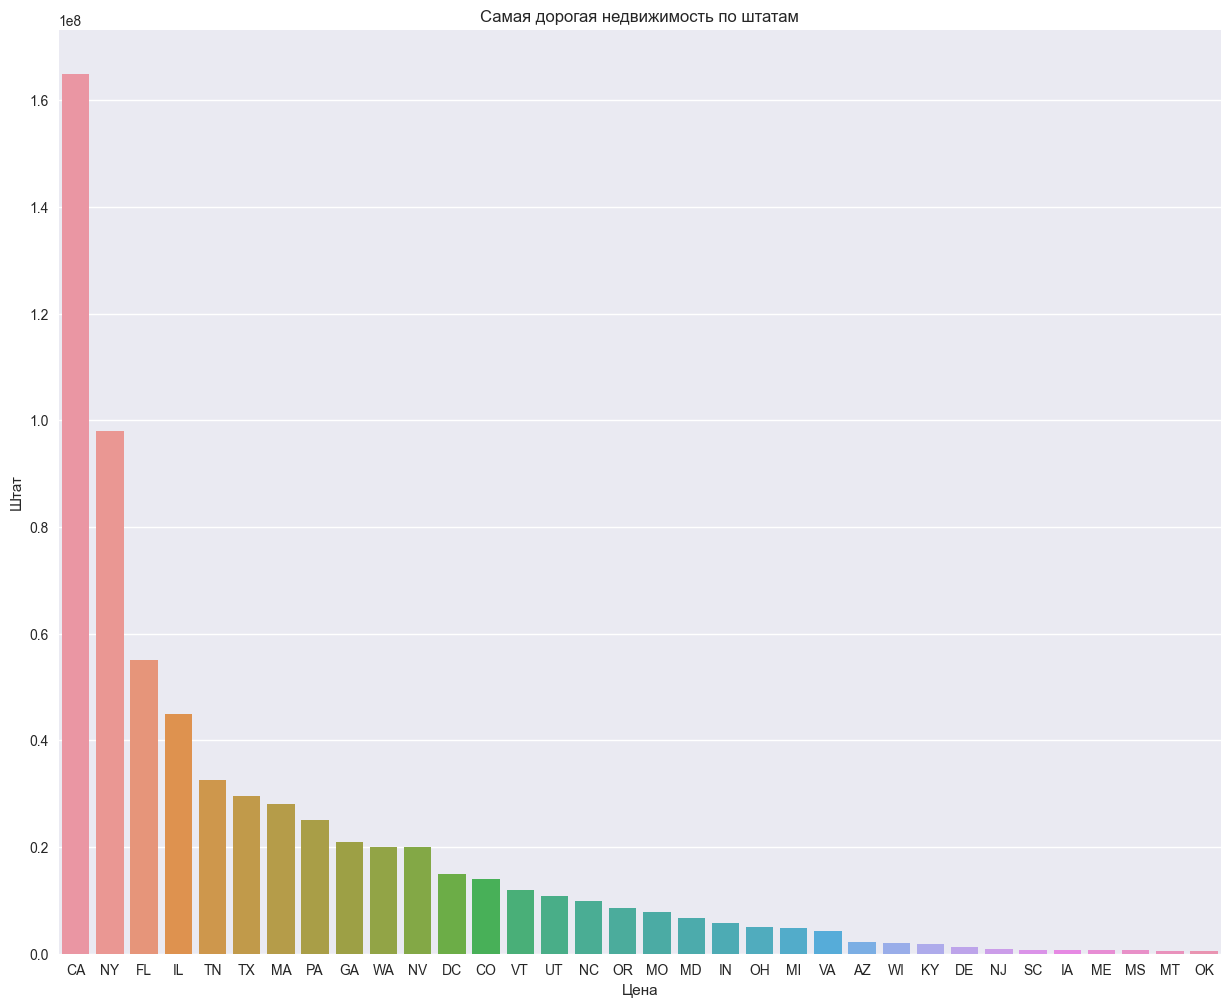

In [371]:
# посторим визуализацию максимальной стоимости недвижимости по штатам
max_price_state = drop_data.groupby(by='state', as_index=False)['target'].max().sort_values(by='target', ascending=False)

fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(max_price_state, x='state', y='target', orientation='vertical', ax=ax)
ax.set_title('Самая дорогая недвижимость по штатам')
ax.set_ylabel('Штат')
ax.set_xlabel('Цена')

Топ-3 штатов с самой дорогой недвижимостью:

1. Калифорния (CA)
2. Нью-Йорк (NY)
3. Флорида (FL)

Подробнее посмотрим на цены ниже $1000

In [372]:
drop_data[drop_data['target'] < 1000]

,status,propertyType,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
15530,active,single,2.0,1,1596.0,3.0,TN,1.0,1940.0,1,87120.0,0.0,2.3,0,0
28386,for rent,single,2.0,1,1872.0,2.0,IN,950.0,1900.0,0,5009.0,1.0,2.0,0,0
29147,active,land,0.0,0,73260.0,0.0,FL,750.0,1959.0,0,76230.0,0.0,5.0,1,0
39541,for rent,condo,3.0,1,690.0,2.0,TX,800.0,1978.0,0,9740.0,1.0,3.8,0,0
40732,active,other,1.0,1,15333.0,2.0,TX,825.0,1968.0,0,7200.0,0.0,3.7,0,0
42116,for rent,single,2.0,1,1098.0,2.0,OH,950.0,1925.0,1,5500.0,1.0,3.0,0,0
50632,foreclosure,land,0.0,0,1656.0,0.0,NY,600.0,1873.0,0,1870.0,0.0,2.3,0,0
50954,foreclosure,single,2.0,1,1400.0,3.0,NY,600.0,1900.0,0,1960.0,0.0,2.7,0,0
73243,for rent,single,2.0,1,2010.0,4.0,NV,600.0,1959.0,1,9278.0,0.0,4.0,0,0
82349,for rent,single,3.0,1,804.0,4.0,TN,900.0,2000.0,1,27443.0,1.0,7.0,1,0


In [373]:
drop_data[drop_data['target'] < 1000].status.value_counts()

status
for rent       23
foreclosure    17
active          8
other           1
Name: count, dtype: int64

Text(0.5, 1.0, 'Стоимость  менее $1000')

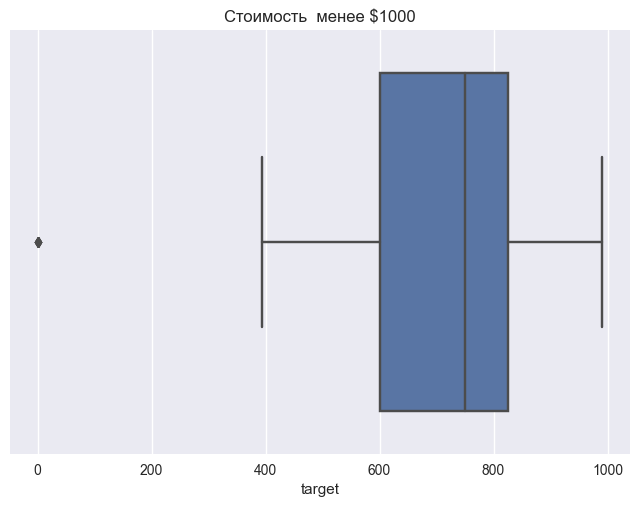

In [374]:
boxplot = sns.boxplot(data=drop_data[drop_data.target < 1000], x='target')
boxplot.set_title('Стоимость  менее $1000')

In [375]:
drop_data[drop_data['target'] < 1000].target.value_counts(sort=True)

target
600.0    12
1.0       7
750.0     7
950.0     3
800.0     3
825.0     3
900.0     2
875.0     2
700.0     2
500.0     2
990.0     1
975.0     1
393.0     1
850.0     1
925.0     1
890.0     1
Name: count, dtype: int64

У самой недорогой недвижимости цена варьируется от 400$ до 1000$. Есть выбросы в районе 0. Если посмотреть равна 1.  
Низкая стоимость обусловлена некоторыми факторами:  
- объект, лишенный права выкупа статус  **foreclosure**
- объект сдаваемый в аренду (цена за месяц аренды)
- очень низкий средний уровень школ. Возможно это неблагоприятные районы или гетто
- практически вся недвижимость старая.   

Скорее всего, такие данные нельзя считать ошибочными, но они выбиваются из общей массы

#### Статистический тест на нормальность распределения данных

Проверка визуально на нормальность

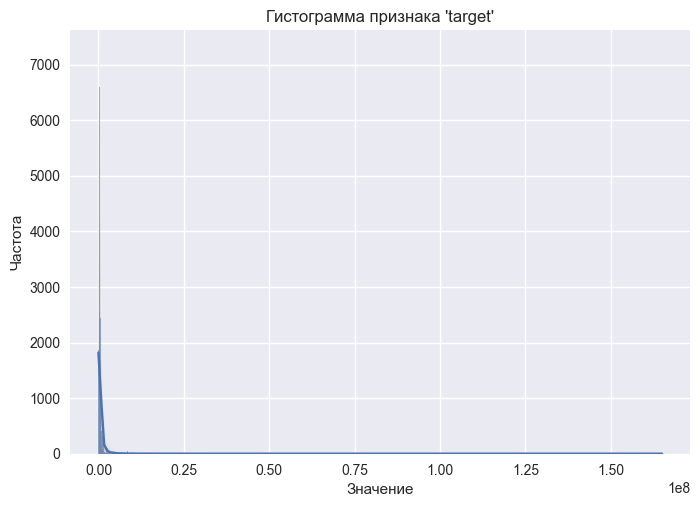

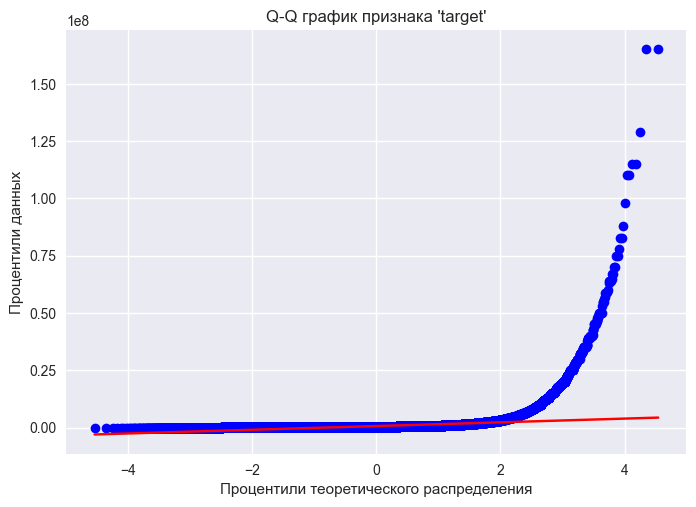

In [376]:
# Гистограмма
sns.histplot(drop_data["target"], kde=True)
plt.title("Гистограмма признака 'target'")
plt.xlabel("Значение")
plt.ylabel("Частота")
plt.show()

# Q-Q график
stats.probplot(drop_data["target"], dist="norm", plot=plt)
plt.title("Q-Q график признака 'target'")
plt.xlabel("Процентили теоретического распределения")
plt.ylabel("Процентили данных")
plt.show()


По гистограмме сложно что, то понять.  По Q-Q графику видно, что практически все данные лежат на одной прямой, что говорило бы о нормальном распределении, но в конце графика идет резкий всплеск. Это обусловленно, что Q-Q график чувствителен к выбросам. Визуально просмотрели,что некоторые данные **target** (которые слишком маленькие ил  большие вполне реальные ситуации имогут не  являться выбросами) поэтому нужно провести дополнительные статистические тесты.

• Параметрические тесты: Более чувствительны к выбросам, которые могут исказить результаты.  
• Непараметрические тесты: Менее чувствительны к выбросам  
Выберем непараметрический тест

Проверим гипотезу о нормальности распределения данных в признаке target с помощью теста Шапиро — Уилка при уровне значимости &alpha; = 0.05

H0 = 'Данные в признаке target распределены нормально'  
Ha = 'Данные в признаке target не распределены нормально.Отвергаем нулевую гипотезу'

In [377]:
# проверка гипотезы о нормальности распределения
# задаём уровень значимости
alpha = 0.05
# проводим тест Шапиро — Уилка
_, p = stats.shapiro(drop_data.target)

print('p-value = %.3f' % (p))
# интерпретируем результат
if p <= alpha:
    print('Распределение не нормальное')
else:
    print('Распределение нормальное')


p-value = 0.000
Распределение не нормальное


Так как данные не распределены нормально, для очистки от выбросов будем использовать метод z-отклонений с логарифмированием признаков.

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3 &sigma;
)

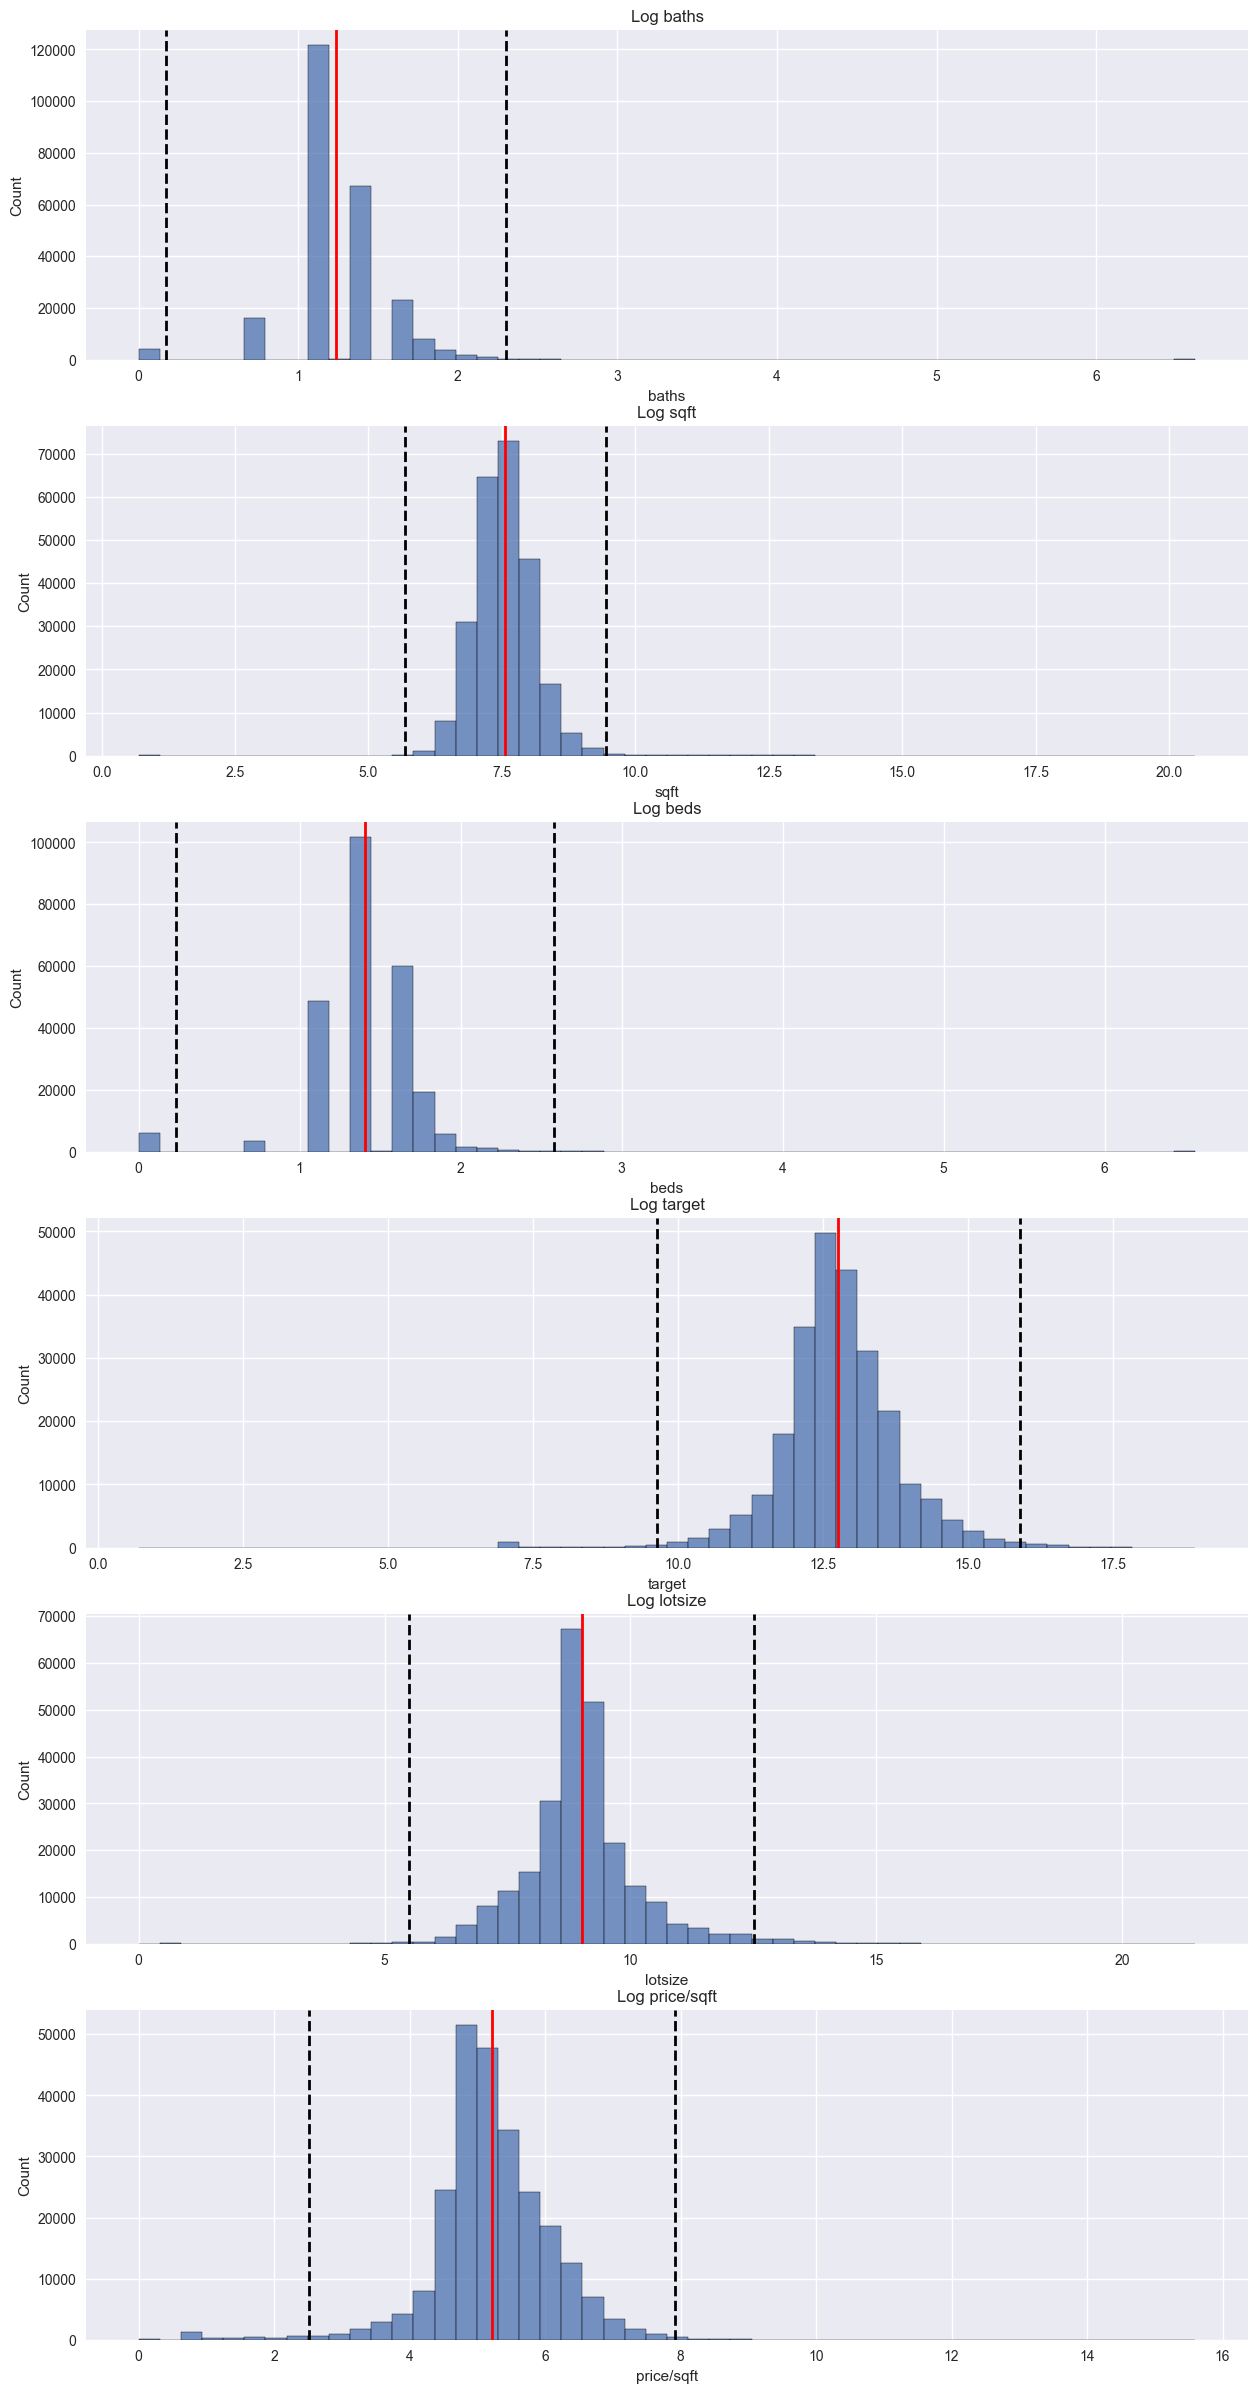

In [378]:

# строим гистограммы распределения числовых признаков в  логарифмированном виде
fig, axes = plt.subplots(len(col_num), figsize=(15, 30))
for i, col in enumerate(col_num):
    #Логарифмируем
    log_col = np.log(drop_data[col]+1)
    #Строим гистограмму в логарифмическом масштабе
    log_boxplot = sns.histplot(data=log_col, bins=50, ax=axes[i])
    log_boxplot.set_title(f"Log {col.title().lower()}")
    #Добавляем вертикальные линии для среднего и 3 стандартных отклонений влево и вправо от среднего
    axes[i].axvline(log_col.mean(), color='red', lw=2)
    axes[i].axvline(log_col.mean()+ 3 *log_col.std(), color='k', ls='--', lw=2)
    axes[i].axvline(log_col.mean()- 3 *log_col.std(), color='k', ls='--', lw=2)

In [379]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [380]:
#Производим очистку
for col in col_num:
    outliers, cleaned = outliers_z_score(drop_data, col, log_scale=True)
    print(f'Число записей до очистки признака {col}: {drop_data.shape[0]}')
    print(f'Число выбросов по методу z-отклонения признака {col}: {outliers.shape[0]}')
    print(f'Число записей после очистки признака {col}: {cleaned.shape[0]}\n')
    drop_data = cleaned

Число записей до очистки признака baths: 249025
Число выбросов по методу z-отклонения признака baths: 5312
Число записей после очистки признака baths: 243713

Число записей до очистки признака sqft: 243713
Число выбросов по методу z-отклонения признака sqft: 1582
Число записей после очистки признака sqft: 242131

Число записей до очистки признака beds: 242131
Число выбросов по методу z-отклонения признака beds: 2492
Число записей после очистки признака beds: 239639

Число записей до очистки признака target: 239639
Число выбросов по методу z-отклонения признака target: 3083
Число записей после очистки признака target: 236556

Число записей до очистки признака lotsize: 236556
Число выбросов по методу z-отклонения признака lotsize: 3924
Число записей после очистки признака lotsize: 232632

Число записей до очистки признака price/sqft: 232632
Число выбросов по методу z-отклонения признака price/sqft: 1994
Число записей после очистки признака price/sqft: 230638



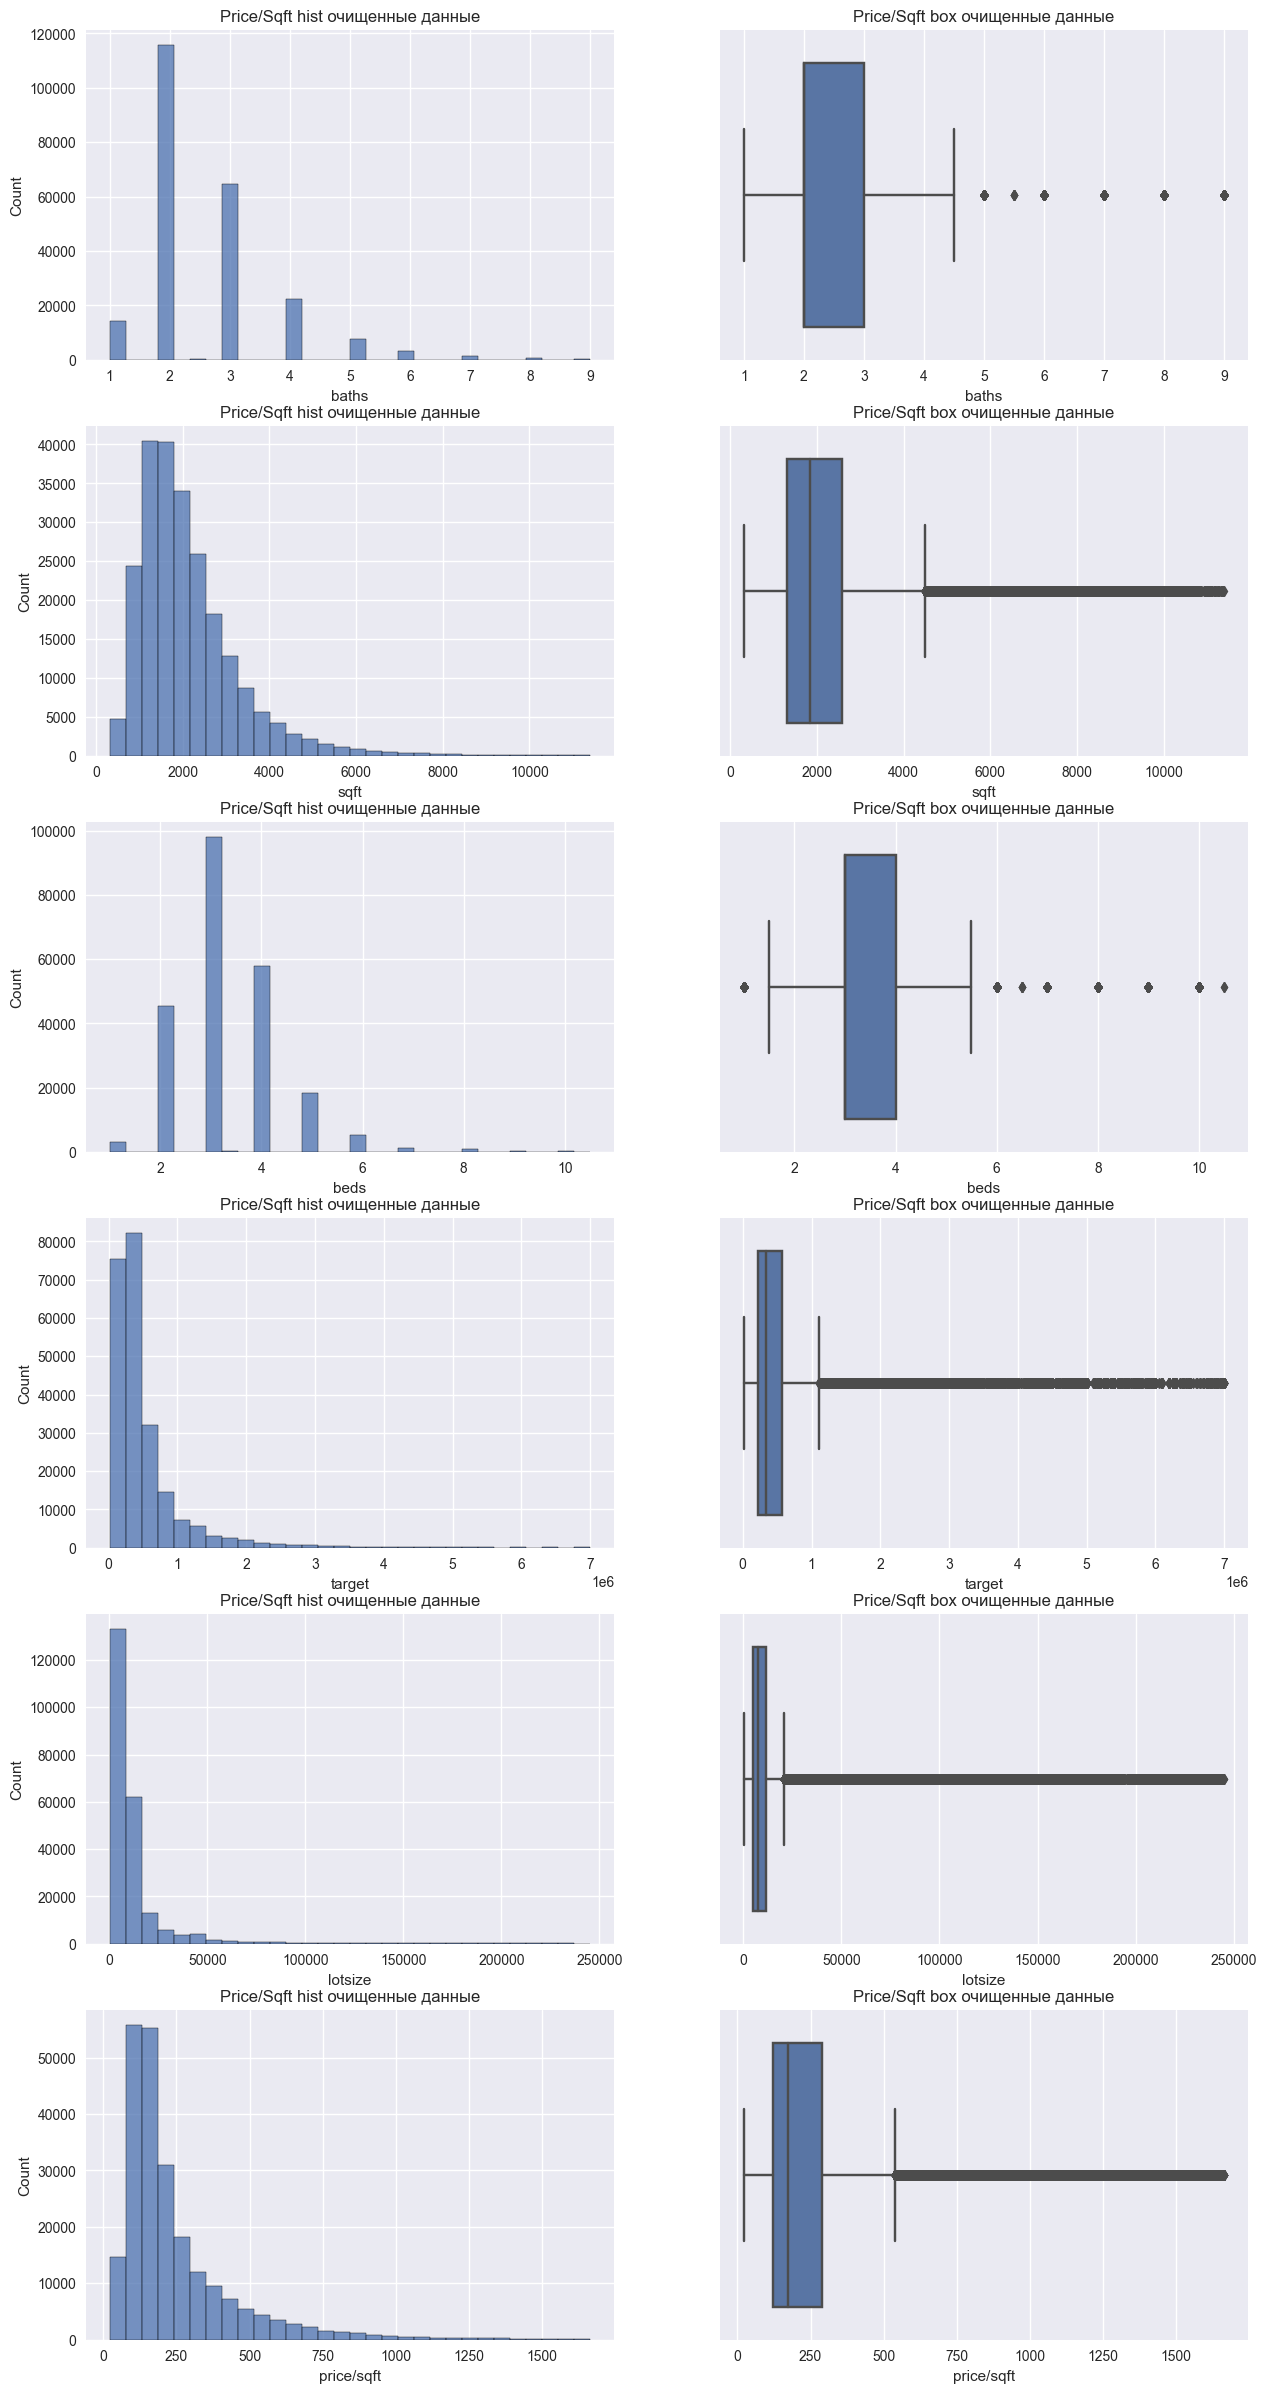

In [381]:
# визуализация распределений числовых признаков после очистки
fig, axes = plt.subplots(len(col_num), 2, figsize=(15, 30))
for i, col in enumerate(col_num):
    num_histplot = sns.histplot(data=drop_data, x=col, bins=30, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist очищенные данные")
    num_boxplot = sns.boxplot(data=drop_data, x=col, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box очищенные данные")

Text(0.5, 0, 'Тип недвижимости')

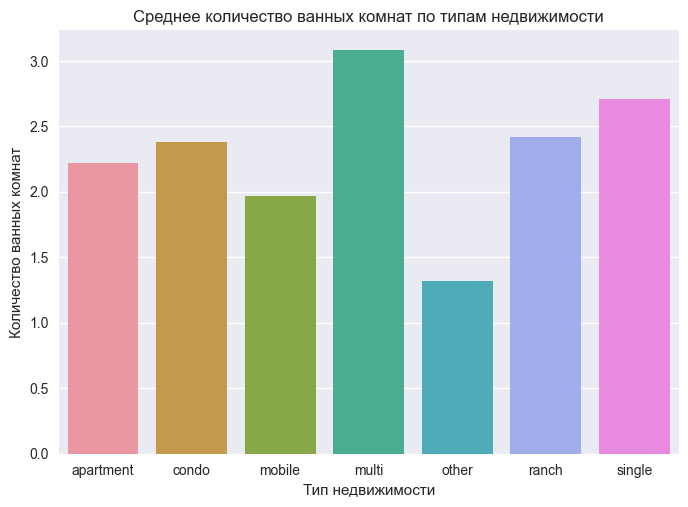

In [382]:
# построим визуализацию зависимости среднего количества ванных комнат от типа недвижимости
baths_type = drop_data.groupby(by='propertyType', as_index=False).baths.mean()
bar = sns.barplot(baths_type, x='propertyType', y='baths')
bar.set_title('Среднее количество ванных комнат по типам недвижимости')
bar.set_ylabel('Количество ванных комнат')
bar.set_xlabel('Тип недвижимости')

Text(0.5, 0, 'Тип недвижимости')

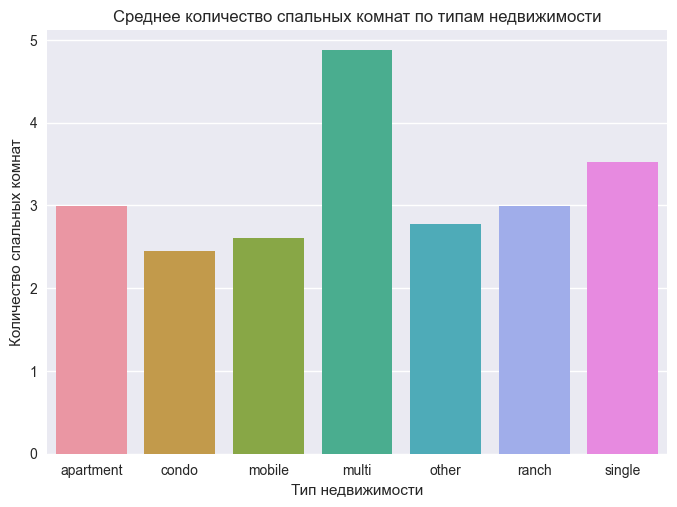

In [383]:
# построим визуализацию зависимости среднего количества спален комнат от типа недвижимости
baths_type = drop_data.groupby(by='propertyType', as_index=False).beds.mean()
bar = sns.barplot(baths_type, x='propertyType', y='beds')
bar.set_title('Среднее количество спальных комнат по типам недвижимости')
bar.set_ylabel('Количество спальных комнат')
bar.set_xlabel('Тип недвижимости')


Максимумы представлены у недвижимости multi

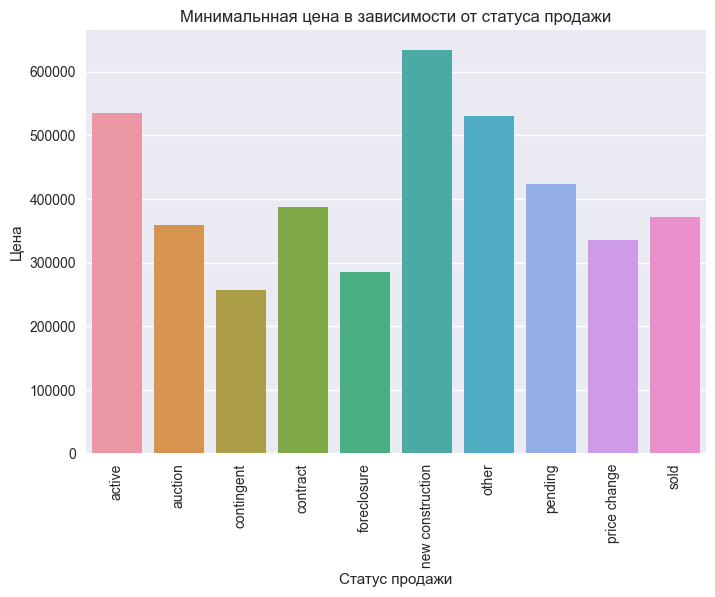

In [384]:
# построим визуализацию средней цены в зависимости от статуса продажи
price_status = drop_data.groupby(by='status', as_index=False).target.mean()
ax = sns.barplot(price_status, x='status', y='target')
ax.set_title('Минимальнная цена в зависимости от статуса продажи')
ax.set_ylabel('Цена')
ax.set_xlabel('Статус продажи')
ax.tick_params(axis='x', rotation=90)


Наибольшая цена у объектов недвижимости, имеющих статус new construction(новостройка), active и other. Наименьшая цена у объектов contingent

Построение графиков зависимости числовых признаков с целевой переменной

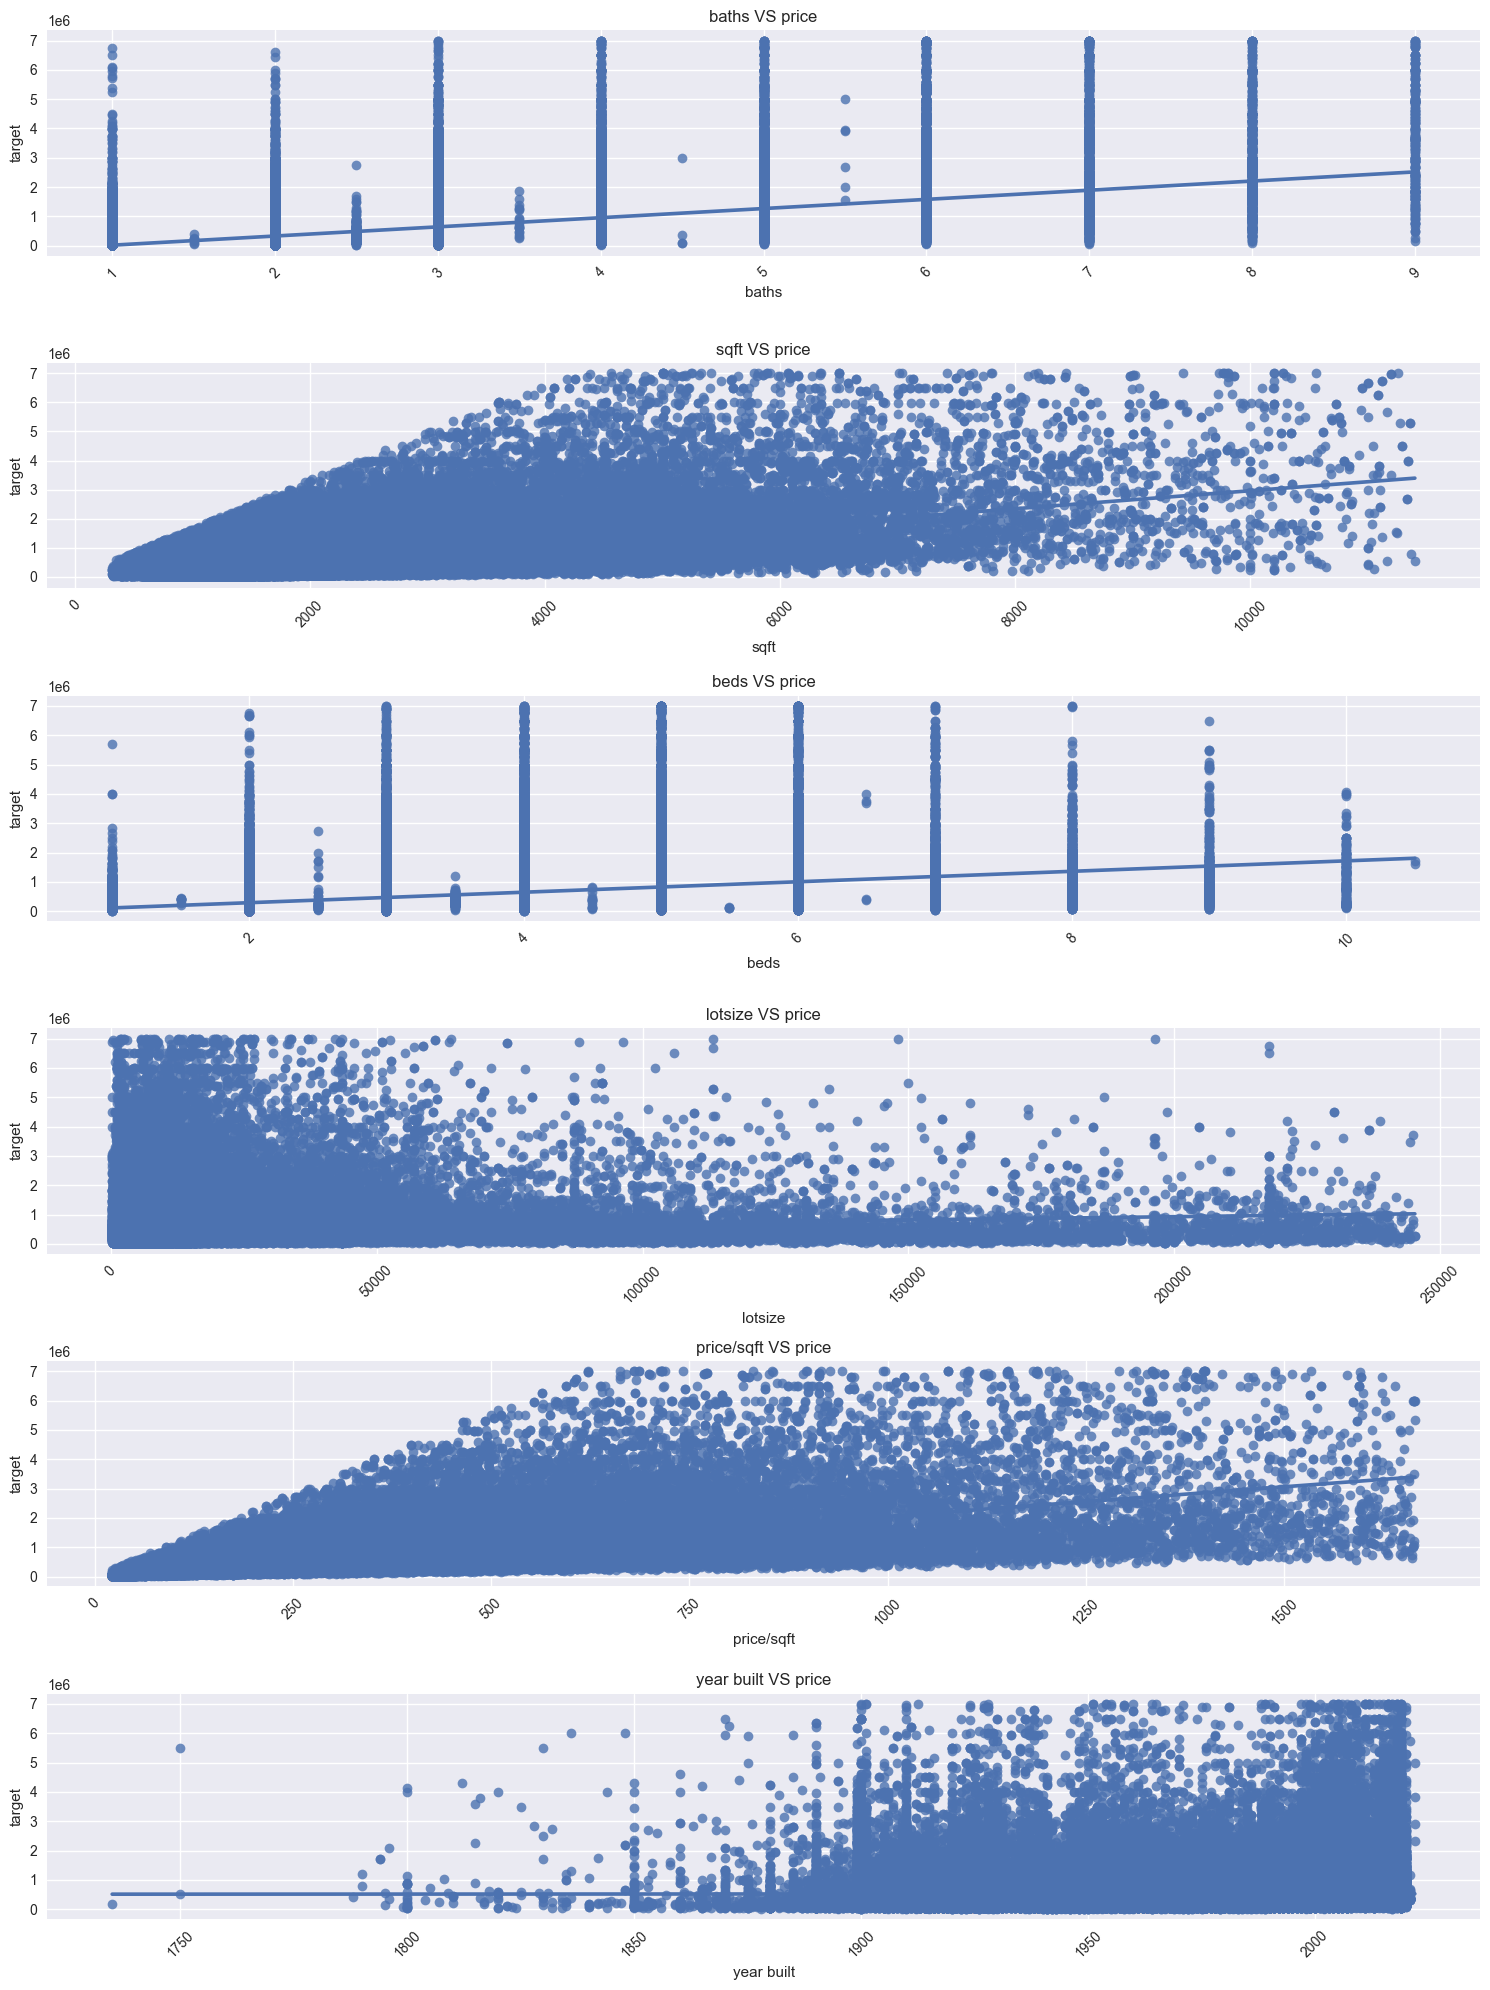

In [385]:
# числовые признаки кроме целевого признака
col_num = ['baths','sqft','beds','lotsize','price/sqft','year built']

fig, axes = plt.subplots(len(col_num), figsize=(15, 20))
for i, col in enumerate(col_num): 
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=drop_data, x=col, y='target', ax=axes[i])
    regplot.set_title('{} VS price'.format(col))
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Цена недвижимости напрямую зависит от площади (sqft) и цены за единицу площади (price/sqft)

In [386]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230638 entries, 0 to 375442
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   status              230638 non-null  object 
 1   propertyType        230638 non-null  object 
 2   baths               230638 non-null  float64
 3   fireplace           230638 non-null  int64  
 4   sqft                230638 non-null  float64
 5   beds                230638 non-null  float64
 6   state               230638 non-null  object 
 7   target              230638 non-null  float64
 8   year built          230638 non-null  float64
 9   parking             230638 non-null  int32  
 10  lotsize             230638 non-null  float64
 11  price/sqft          230638 non-null  float64
 12  mean_rating_school  230638 non-null  float64
 13  count_school        230638 non-null  int64  
 14  pool                230638 non-null  int64  
dtypes: float64(8), int32(1), int64(3), obje

In [387]:
drop_data.head()

,status,propertyType,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,mean_rating_school,count_school,pool
0,active,single,3.0,1,2900.0,4.0,NC,418000.0,2019.0,0,30274.5,144.0,5.2,0,0
1,active,single,3.0,1,1947.0,3.0,WA,310000.0,2019.0,0,5828.0,159.0,4.0,0,0
2,active,single,2.0,1,3000.0,3.0,CA,2895000.0,1961.0,1,8626.0,965.0,6.7,2,1
3,active,single,8.0,1,6457.0,5.0,TX,2395000.0,2006.0,1,8220.0,371.0,9.2,4,0
5,active,condo,2.0,1,897.0,2.0,PA,209000.0,1920.0,0,680.0,233.0,1.5,0,0


## 4.Отбор признаков

#### Преобразование признаков

In [388]:
# признаки для кодирования типа object(status, propertyType, state) количество уникальных значений
print(f'Количество уникальных  значений status:  {drop_data.status.nunique()}\n')
print(f'Количество уникальных  значений propertyType:  {drop_data.propertyType.nunique()}\n')
print(f'Количество уникальных  значений state:  {drop_data.state.nunique()}')


Количество уникальных  значений status:  10

Количество уникальных  значений propertyType:  7

Количество уникальных  значений state:  34


In [389]:
# выполним однократное кодирование, т.к. число признаков меньше 15
data_cleaned = pd.get_dummies(drop_data, columns=['status', 'propertyType'])
data_cleaned.shape

(230638, 30)

In [390]:
# выполним бинарное кодирование для признака state
bin_encoder = ce.BinaryEncoder(cols=['state']) # указываем столбцы для кодирования
type_bin = bin_encoder.fit_transform(data_cleaned['state'])
data_cleaned = pd.concat([data_cleaned, type_bin], axis=1)


In [391]:
# удаляем признак state
data_cleaned.drop('state', axis=1, inplace=True)

In [392]:
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230638 entries, 0 to 375442
Data columns (total 35 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   baths                    230638 non-null  float64
 1   fireplace                230638 non-null  int64  
 2   sqft                     230638 non-null  float64
 3   beds                     230638 non-null  float64
 4   target                   230638 non-null  float64
 5   year built               230638 non-null  float64
 6   parking                  230638 non-null  int32  
 7   lotsize                  230638 non-null  float64
 8   price/sqft               230638 non-null  float64
 9   mean_rating_school       230638 non-null  float64
 10  count_school             230638 non-null  int64  
 11  pool                     230638 non-null  int64  
 12  status_active            230638 non-null  bool   
 13  status_auction           230638 non-null  bool   
 14  status_co

#### Тепловая карта корреляций

<Axes: >

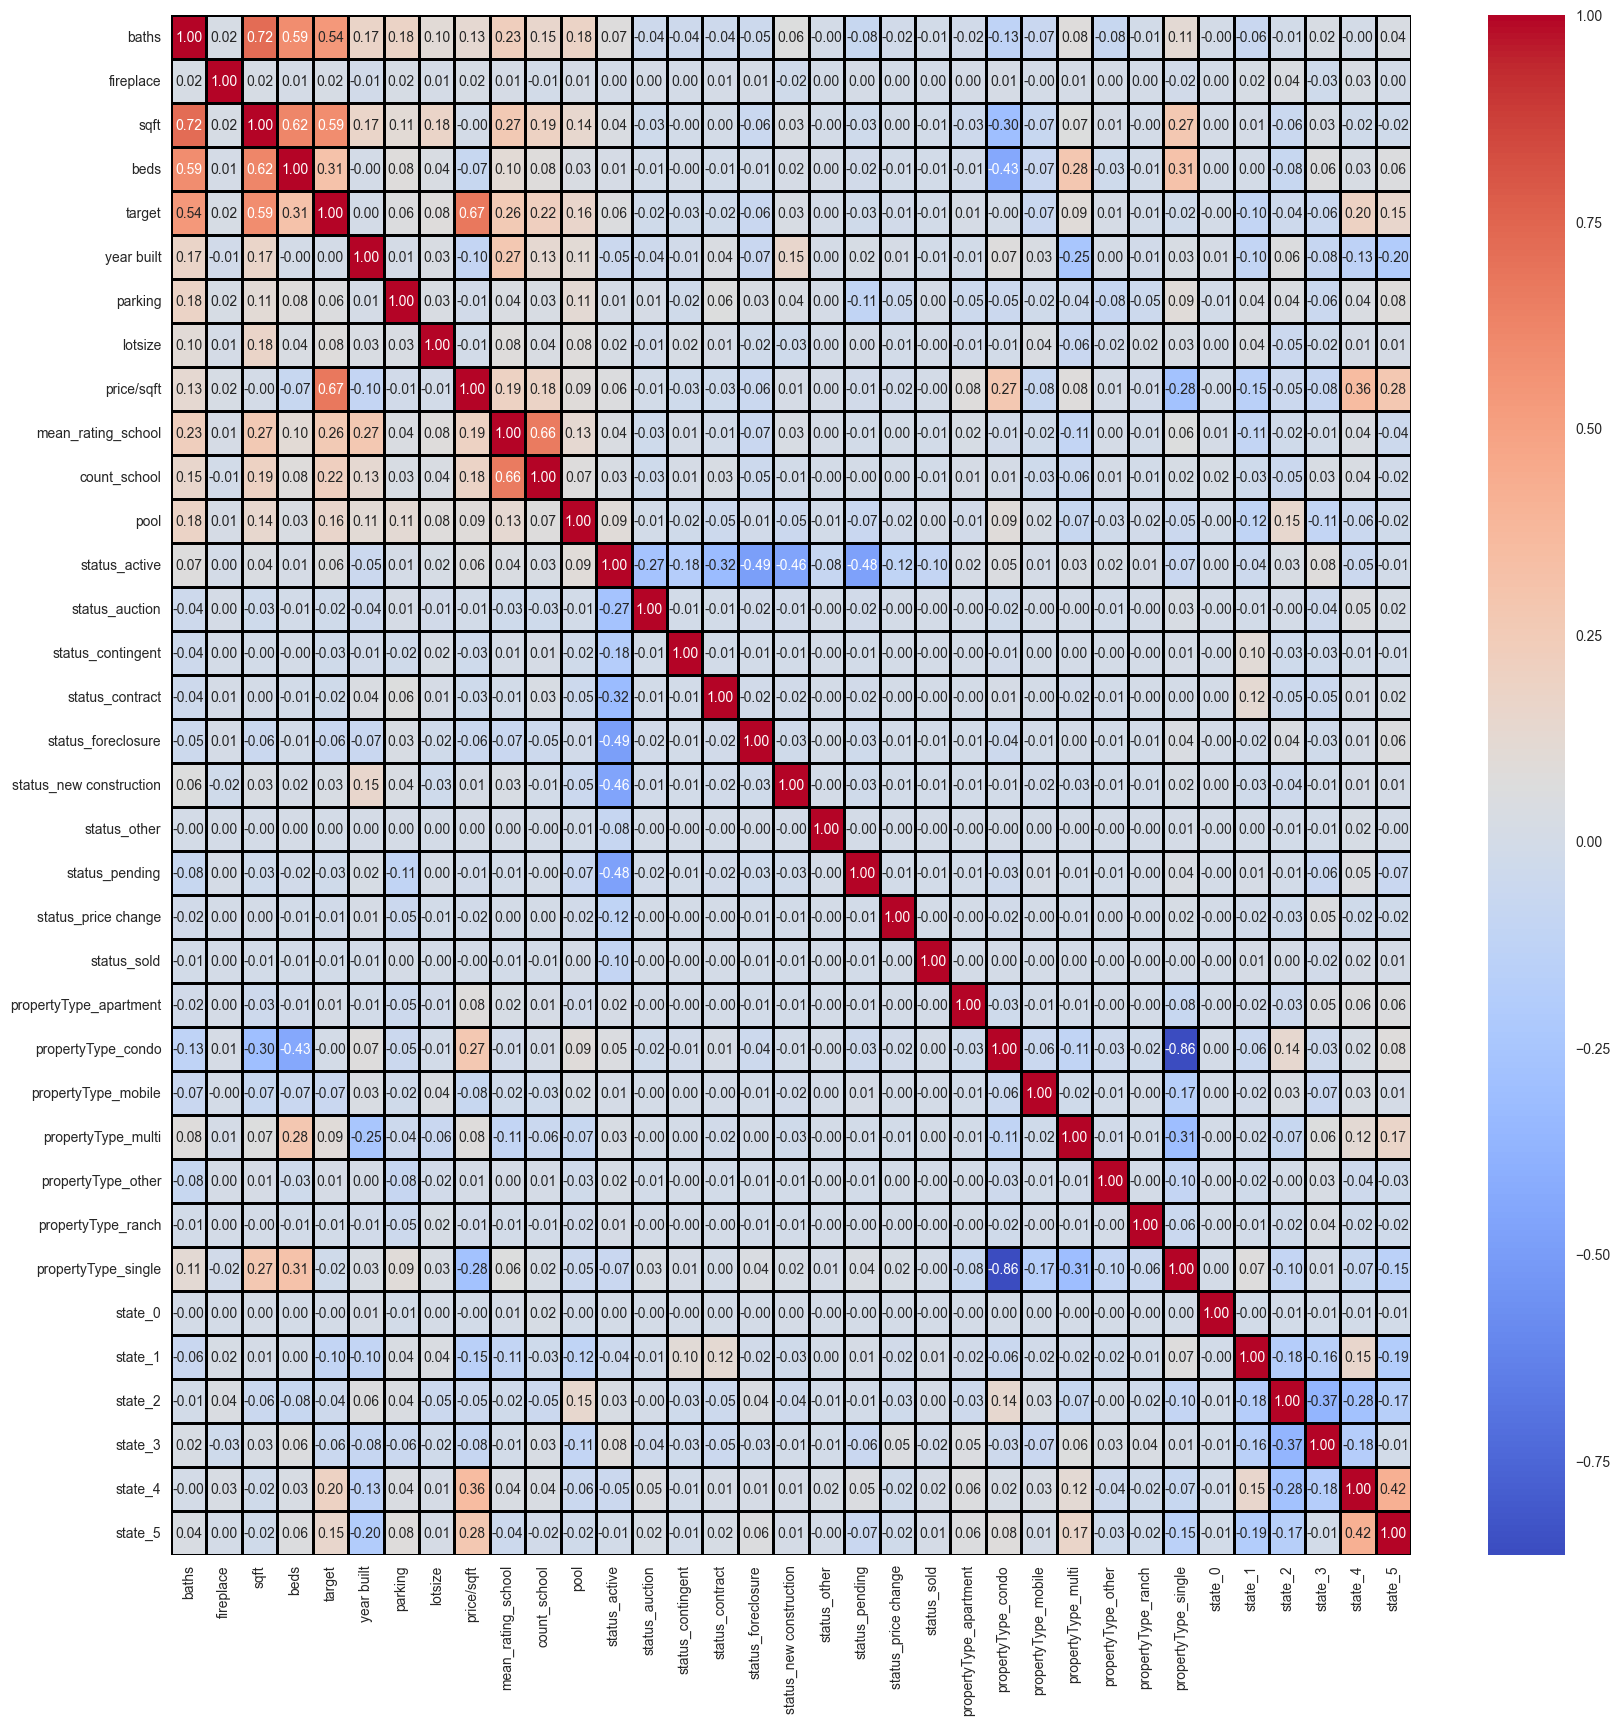

In [393]:
# построим тепловую карту корреляций
fig = plt.figure(figsize=(20, 20))
sns.heatmap(data_cleaned.corr(), cmap='coolwarm', annot=True, fmt=".2f", linewidths=2, linecolor='black')

Будем считать если коэфициент коллениарности ниже 0.9, то мультиколлениарность отсутствует. Максимальный клэфициент равен 0.86 

Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую

In [394]:
X = data_cleaned.drop(['target'], axis=1)
y = data_cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

Отберем наиболее важные признаки, которые сильнее всего связаны с целевой переменной

In [395]:
# с помощью SelectKBest отберем 20 наиболее подходящих признаков
selector = SelectKBest(score_func=f_regression, k=20)
selector.fit(X_train, y_train)

cols = selector.get_feature_names_out()
cols

array(['baths', 'sqft', 'beds', 'parking', 'lotsize', 'price/sqft',
       'mean_rating_school', 'count_school', 'pool', 'status_active',
       'status_contingent', 'status_foreclosure',
       'status_new construction', 'propertyType_mobile',
       'propertyType_multi', 'state_1', 'state_2', 'state_3', 'state_4',
       'state_5'], dtype=object)

#### Нормализация данных

Для наглядности построим визуализацию распределения данных до нормализации

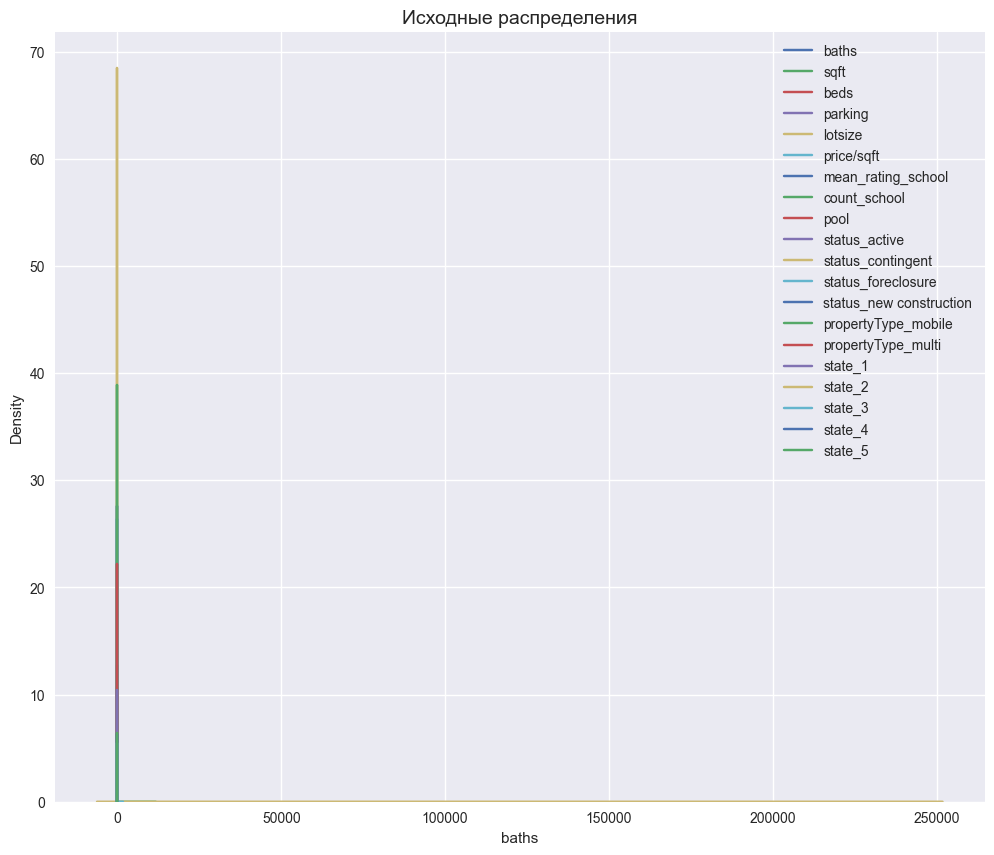

In [396]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Исходные распределения', fontsize=14)

for col in cols:
    sns.kdeplot(X_train[col], ax=ax, label=col)
plt.legend()

In [397]:
# инициализируем нормализатор MinMaxScaler
scaler = MinMaxScaler()
# Вычисляем параметры для нормализации: min и max для каждого столбца
scaler.fit(X_train[cols])
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train[cols])
X_test_scaled = scaler.transform(X_test[cols])

# промежуточный датасет для визуализации
df_scaled = pd.DataFrame(X_train_scaled, columns=cols)

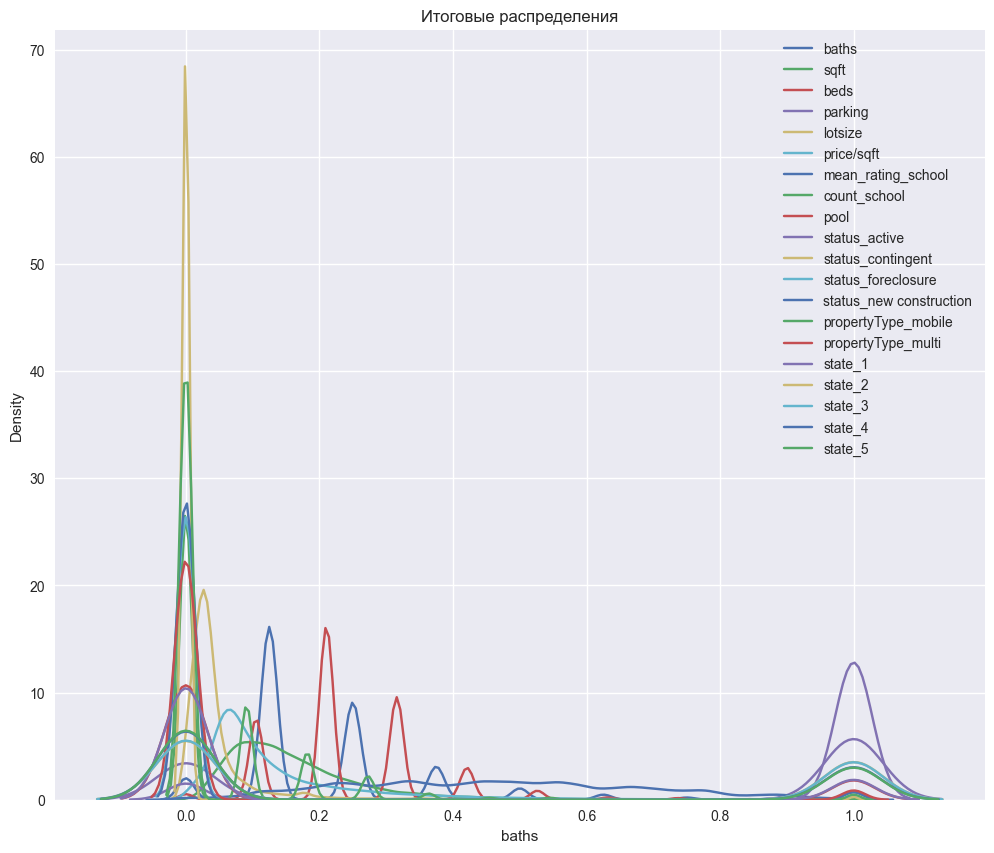

In [398]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_title('Итоговые распределения')

for col in cols:
    sns.kdeplot(df_scaled[col], ax=ax, label=col)
plt.legend()

## 5. Построение модели

In [399]:
# Списки для пстроения сводной таблицы
model = [] # наименование модели
test_R2 = [] # значение R2 модели
test_MAPE = [] # значения MAPE модели 
test_MAE = [] # значения MAE модели


In [400]:
# Функция для расчета и вывода на экран метрик модели
def metrics(y_train, y_train_pred, y_test, y_test_pred):
    print('Train R2: {:.3f}'.format(r2_score(y_train, y_train_pred)))
    print('Train MAE: {:.3f}'.format(mean_absolute_error(y_train, y_train_pred)))
    print('Train MAPE: {:.3f}'.format(mean_absolute_percentage_error(y_train, y_train_pred)*100))
    print('\n')
    print('Test R2: {:.3f}'.format(r2_score(y_test, y_test_pred)))
    print('Test MAE: {:.3f}'.format(mean_absolute_error(y_test, y_test_pred)))
    print('Test MAPE: {:.3f}'.format(mean_absolute_percentage_error(y_test, y_test_pred)*100)) 

#### Baseline модель

Базовая модель может быть просто средним значением целевого признака в обучающем наборе данных.

In [401]:
def baseline_model(y_train, y_test):
    # Вычисляем среднее значение признака на обучающей выборке
    mean_y = np.mean(y_train)
    # Делаем предсказания базовой модели для обучающей выборки
    y_train_baseline = np.full(y_train.shape, mean_y)
    # Делаем предсказания базовой модели для тестовой выборки
    y_test_baseline = np.full(y_test.shape, mean_y)
    return y_train_baseline, y_test_baseline

In [402]:
#обучаем модель
y_train_base, y_test_base = baseline_model(y_train, y_test)

In [403]:
# выводим метрики
metrics(y_train, y_train_base, y_test, y_test_base)

Train R2: 0.000
Train MAE: 360995.635
Train MAPE: 130.192


Test R2: -0.000
Test MAE: 362037.572
Test MAPE: 130.425


Значение R2 = 0 указывает на то, что модель не имеет никакой предсказательной силы. Это означает, что модель не может предсказать целевую переменную лучше, чем просто угадывать среднее значение.Будем расматривать данную модель как отправную точку.

In [404]:
model.append('Baseline модель')
test_MAE.append(round(mean_absolute_error(y_test, y_test_base),3))
test_R2.append(round(r2_score(y_test, y_test_base), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_base)*100, 3))

#### LinearRegression

In [405]:
# обучаем линейную регрессию и рассчитываем метрики качества
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)
y_train_lr = lr.predict(X_train_scaled)
y_test_lr = lr.predict(X_test_scaled)
metrics(y_train, y_train_lr, y_test, y_test_lr)

Train R2: 0.807
Train MAE: 150085.980
Train MAPE: 54.208


Test R2: 0.810
Test MAE: 149644.488
Test MAPE: 53.901


In [406]:
model.append('LinearRegression модель')
test_MAE.append(round(mean_absolute_error(y_test, y_test_lr),3))
test_R2.append(round(r2_score(y_test, y_test_lr), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_lr)*100, 3))

#### Стохастический градиентный спуск(SGDRegressor)

In [407]:
# обучаем линейную регрессию и рассчитываем метрики качества без настройки параметров
sgd_lr = linear_model.SGDRegressor(random_state=42)
sgd_lr.fit(X_train_scaled, y_train)
y_train_sgd = sgd_lr.predict(X_train_scaled)
y_test_sgd = sgd_lr.predict(X_test_scaled)
metrics(y_train, y_train_sgd, y_test, y_test_sgd)

Train R2: 0.807
Train MAE: 149400.004
Train MAPE: 54.149


Test R2: 0.810
Test MAE: 148969.992
Test MAPE: 53.843


In [408]:
model.append('SGDRegressor модель по умолчанию')
test_MAE.append(round(mean_absolute_error(y_test, y_test_sgd),3))
test_R2.append(round(r2_score(y_test, y_test_sgd), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_sgd)*100, 3))

In [409]:
# Параметры для подбора
param_grid = {
    'loss': ['squared_error'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [0.001, 0.01, 0.1],  
    'learning_rate': ['constant', 'optimal', 'invscaling']
   }

In [410]:


# Создаем объект перекрестной проверки
cv = StratifiedKFold(n_splits=5)

# Создаем объект поиска сетки
grid_search = GridSearchCV(sgd_lr, param_grid, cv=cv, n_jobs=-1)

# Обучаем модель с подобранными параметрами
grid_search.fit(X_train_scaled, y_train)

# Получаем лучшие параметры
best_params = grid_search.best_params_

# Выводим лучшие параметры
print("Лучшие параметры:")
print(best_params)


Лучшие параметры:
{'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l1'}


In [411]:
# обучаем линейную регрессию и рассчитываем метрики качества с полученными параметрами
sgd_lr_param = linear_model.SGDRegressor(alpha=0.001, learning_rate='optimal', loss='squared_error', penalty='l1', random_state=42)
sgd_lr_param.fit(X_train_scaled, y_train)
y_train_sgdp = sgd_lr_param.predict(X_train_scaled)
y_test_sgdp = sgd_lr_param.predict(X_test_scaled)
metrics(y_train, y_train_sgdp, y_test, y_test_sgdp)

Train R2: 0.807
Train MAE: 150130.738
Train MAPE: 54.365


Test R2: 0.810
Test MAE: 149701.116
Test MAPE: 54.060


Для подбора параметров было взято минимальное количество для поборки оптимального из-за долгого расчета. Из тех которые подбирались  лучшими оказались 'alpha': 0.001, 'learning_rate': 'optimal', 'loss': 'squared_error', 'penalty': 'l1'. Но метрики получились хуже, чем с параметрами по умолчанию. R2 без  изменения, MAE и MAPE ухудшились. Оставляем с параметрами по умолчанию.

In [412]:
model.append('SGDRegressor модель с параметрами')
test_MAE.append(round(mean_absolute_error(y_test, y_test_sgdp),3))
test_R2.append(round(r2_score(y_test, y_test_sgdp), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_sgdp)*100, 3))

#### Дерево решений для задачи регрессии(DecisionTreeRegressor)

In [413]:
# обучаем решающие деревья с параметрами по умолчанию
dtr = tree.DecisionTreeRegressor(random_state=42)
dtr.fit(X_train_scaled, y_train)
y_train_dtr = dtr.predict(X_train_scaled)
y_test_dtr = dtr.predict(X_test_scaled)
metrics(y_train, y_train_dtr, y_test, y_test_dtr)

Train R2: 1.000
Train MAE: 5.328
Train MAPE: 0.001


Test R2: 0.999
Test MAE: 4081.871
Test MAPE: 0.631


In [428]:
model.append('DecisionTreeRegressor модель')
test_MAE.append(round(mean_absolute_error(y_test, y_test_dtr),3))
test_R2.append(round(r2_score(y_test, y_test_dtr), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_dtr)*100, 3))

In [414]:
param_grid = {'max_depth': list(range(2, 15)),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 3, 5]}


In [415]:

grid_search = GridSearchCV(dtr, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_parameters = grid_search.best_params_

print(best_parameters)

{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [416]:
# обучаем решающие деревья с параметрами 
dtr_param = tree.DecisionTreeRegressor(max_depth=14, min_samples_leaf=1, min_samples_split=5, random_state=42)
dtr_param.fit(X_train_scaled, y_train)
y_train_dtrp = dtr_param.predict(X_train_scaled)
y_test_dtrp = dtr_param.predict(X_test_scaled)
metrics(y_train, y_train_dtrp, y_test, y_test_dtrp)

Train R2: 1.000
Train MAE: 3367.589
Train MAPE: 0.946


Test R2: 0.999
Test MAE: 5992.821
Test MAPE: 1.218


In [429]:
model.append('DecisionTreeRegressor модель с параметрами')
test_MAE.append(round(mean_absolute_error(y_test, y_test_dtrp),3))
test_R2.append(round(r2_score(y_test, y_test_dtrp), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_dtrp)*100, 3))

С параметрами  по умолчанию, модель показала очень хорошие метрики R2 и MAPE.  
* Тренировочный MAPE: 0,001 указывает на очень хорошую точность модели на тренировочном наборе данных. Это означает, что модель может очень точно предсказывать целевую переменную на данных, которые она видела во время обучения.
* Тестовый MAPE: 0,631 указывает на то, что точность модели на тестовом наборе данных значительно ниже. Это означает, что модель не может обобщить свои знания на новые, невидимые данные.
* Разница между тренировочным и тестовым MAPE (0,63) указывает на значительную переобученность модели. Модель слишком сильно подгоняется к данным обучения и не может хорошо работать на новых данных.  
  
С параметрами которые подобрали R2 без изменений, но МАРЕ незначительно ухудшилось.  
* Тренировочный MAPE: 0,946
* Тестовый MAPE: 1,218 
* Разница между тренировочным и тестовым MAPE (0,272) указывает на некоторую переобученность модели. Однако переобучение не такое сильное, как с параметрами по умолчанию.  


#### Ансамблевый алгоритм регрессии(RandomForestRegressor)

In [417]:
# обучим модель с  параметрами по умолчанию
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train_scaled, y_train)
y_train_rfr = rfr.predict(X_train_scaled)
y_test_rfr = rfr.predict(X_test_scaled)
metrics(y_train, y_train_rfr, y_test, y_test_rfr)

Train R2: 1.000
Train MAE: 781.974
Train MAPE: 0.133


Test R2: 1.000
Test MAE: 1915.446
Test MAPE: 0.334


In [430]:
model.append('RandomForestRegressor модель')
test_MAE.append(round(mean_absolute_error(y_test, y_test_rfr),3))
test_R2.append(round(r2_score(y_test, y_test_rfr), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_rfr)*100, 3))

Выполним подбор гипрепараметров RandomForestRegressor с помощью optuna

In [418]:
def optuna_rfr(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = r2_score(y_train, model.predict(X_train_scaled))

  return score

In [419]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rfr, n_trials=10)

[I 2024-05-01 15:18:21,196] A new study created in memory with name: RandomForestRegressor


[I 2024-05-01 15:21:52,779] Trial 0 finished with value: 0.9999366761234931 and parameters: {'n_estimators': 181, 'max_depth': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9999366761234931.
[I 2024-05-01 15:23:59,336] Trial 1 finished with value: 0.9997573869161602 and parameters: {'n_estimators': 189, 'max_depth': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9999366761234931.
[I 2024-05-01 15:27:06,310] Trial 2 finished with value: 0.9999131993764339 and parameters: {'n_estimators': 174, 'max_depth': 18, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9999366761234931.
[I 2024-05-01 15:29:19,015] Trial 3 finished with value: 0.9999520095774809 and parameters: {'n_estimators': 114, 'max_depth': 15, 'min_samples_leaf': 2}. Best is trial 3 with value: 0.9999520095774809.
[I 2024-05-01 15:31:49,870] Trial 4 finished with value: 0.9998202250345593 and parameters: {'n_estimators': 176, 'max_depth': 13, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.999

CPU times: total: 26min 51s
Wall time: 27min 4s


In [420]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 114, 'max_depth': 15, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 1.00


In [421]:
# обучим модель с  параметрами подобранные optuna
rfr_param = RandomForestRegressor(**study.best_params, min_samples_split=20, random_state=42)
rfr_param.fit(X_train_scaled, y_train)
y_train_rfrp = rfr_param.predict(X_train_scaled)
y_test_rfrp = rfr_param.predict(X_test_scaled)
metrics(y_train, y_train_rfrp, y_test, y_test_rfrp)

Train R2: 1.000
Train MAE: 2206.050
Train MAPE: 0.361


Test R2: 1.000
Test MAE: 2724.611
Test MAPE: 0.440


In [431]:
model.append('RandomForestRegressor модель (optuna)')
test_MAE.append(round(mean_absolute_error(y_test, y_test_rfrp),3))
test_R2.append(round(r2_score(y_test, y_test_rfrp), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_rfrp)*100, 3))

Модель при параметрах по умолчанию показала переобучаемость.  
* Train MAPE: 0.133
* Test MAPE: 0.334  


При заданых параметрах MAPE незначительно ухудшилось, но убрали переобучаемость.
* Train MAPE: 0.361
* Test MAPE: 0.440

#### Градиентный бустинг для регрессии(GradientBoostingRegressor)

In [422]:
gbr = GradientBoostingRegressor(random_state=42, verbose=True)

gbr.fit(X_train_scaled, y_train)

y_train_gbr = gbr.predict(X_train_scaled)
y_test_gbr = gbr.predict(X_test_scaled)
metrics(y_train, y_train_gbr, y_test, y_test_gbr)

      Iter       Train Loss   Remaining Time 


         1 338825091424.7595            1.01m
         2 290204163705.6340           45.28s
         3 249140441255.6145           39.29s
         4 214273369749.8867           36.22s
         5 185460754049.1764           34.47s
         6 160795396712.8796           33.51s
         7 139887506369.5442           32.49s
         8 121967422205.4544           31.97s
         9 106652541062.8418           31.45s
        10 93291734616.8367           30.60s
        20 27828903959.2401           25.59s
        30 10008068292.5264           21.74s
        40  4313950627.4567           18.54s
        50  2245984827.2498           15.67s
        60  1474866867.5424           12.64s
        70  1130619427.1860            9.43s
        80   959203394.9663            6.27s
        90   879104781.9384            3.17s
       100   825235680.2313            0.00s
Train R2: 0.998
Train MAE: 16976.035
Train MAPE: 4.924


Test R2: 0.998
Test MAE: 17274.223
Test MAPE: 4.962


In [432]:
model.append('GradientBoostingRegressor модель')
test_MAE.append(round(mean_absolute_error(y_test, y_test_gbr),3))
test_R2.append(round(r2_score(y_test, y_test_gbr), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_gbr)*100, 3))

Выполним подбор гипрепараметров GradientBoostingRegressor с помощью optuna

In [423]:
def optuna_gbr(trial):
  # задаем пространства поиска гиперпараметров

    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 8)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 5)

  # создаем модель
    model = GradientBoostingRegressor(learning_rate=learning_rate, 
                                      n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=42)
  # обучаем модель
    model.fit(X_train_scaled, y_train)
    score = r2_score(y_train, model.predict(X_train_scaled))

    return score

In [424]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study_gbr = optuna.create_study(study_name="GradientBoostingRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study_gbr.optimize(optuna_gbr, n_trials=10)

[I 2024-05-01 15:47:57,099] A new study created in memory with name: GradientBoostingRegressor
[I 2024-05-01 15:49:56,433] Trial 0 finished with value: 0.9998932760794186 and parameters: {'learning_rate': 0.03790432514453578, 'n_estimators': 140, 'max_depth': 8, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9998932760794186.
[I 2024-05-01 15:51:03,340] Trial 1 finished with value: 0.9955138272847133 and parameters: {'learning_rate': 0.022223282485097084, 'n_estimators': 137, 'max_depth': 5, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9998932760794186.
[I 2024-05-01 15:52:05,294] Trial 2 finished with value: 0.9986190950438771 and parameters: {'learning_rate': 0.06223779202745349, 'n_estimators': 217, 'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.9998932760794186.
[I 2024-05-01 15:57:00,021] Trial 3 finished with value: 0.9999427620991416 and parameters: {'learning_rate': 0.

CPU times: total: 24min 39s
Wall time: 24min 47s


In [425]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study_gbr.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study_gbr.best_value))

Наилучшие значения гиперпараметров {'learning_rate': 0.08597616013355588, 'n_estimators': 450, 'max_depth': 8, 'min_samples_split': 10, 'min_samples_leaf': 1}
f1_score на обучающем наборе: 1.00


In [426]:
gbr_p = GradientBoostingRegressor(**study_gbr.best_params, random_state=42, verbose=True)

gbr_p.fit(X_train_scaled, y_train)

y_train_gbrp = gbr_p.predict(X_train_scaled)
y_test_gbrp = gbr_p.predict(X_test_scaled)
metrics(y_train, y_train_gbrp, y_test, y_test_gbrp)

      Iter       Train Loss   Remaining Time 


         1 332983413142.2072            7.02m
         2 278613423963.0122            6.22m
         3 233140015106.4216            5.99m
         4 195086698730.2505            5.88m
         5 163245423075.6477            5.72m
         6 136602123790.3813            5.62m
         7 114312537757.0773            5.54m
         8 95664634458.6068            5.49m
         9 80057766381.6021            5.45m
        10 66994609040.3531            5.40m
        20 11333132830.2716            5.29m
        30  1957137613.8317            5.26m
        40   372305150.3602            5.21m
        50    99999966.1236            5.20m
        60    48135745.6512            5.00m
        70    35986005.1419            4.81m
        80    31576814.2228            4.65m
        90    29307032.3984            4.46m
       100    27825553.7368            4.28m
       200    21350942.6887            2.82m
       300    17531303.2395            1.72m
       400    14755510.9129           35.25s
Tra

In [433]:
model.append('GradientBoostingRegressor модель (optuna)')
test_MAE.append(round(mean_absolute_error(y_test, y_test_gbrp),3))
test_R2.append(round(r2_score(y_test, y_test_gbrp), 3))
test_MAPE.append(round(mean_absolute_percentage_error(y_test, y_test_gbrp)*100, 3))

Модель GradientBoostingRegressor с параметрам по умолчанию показала метрики хуже, чем были до этого у моделей RandomForestRegressor  и DecisionTreeRegressor:
 * Test R2: 0.998
 * Test MAE: 17274.223
 * Test MAPE: 4.962  

 
С параметрами подобранные Optuna GradientBoostingRegressor показала приемлемые результаты. И Самое главное нет переобучения.
 * Test R2: 1.000
 * Test MAE: 3141.696
 * Test MAPE: 0.675


In [437]:
# сохранение модели
with open('model.pkl', 'wb') as output:
       pickle.dump(model, output)

## Итоговые результаты

In [434]:
metrics_models = {
        'Model': model,
        'Test MAE': test_MAE,
        'Test MAPE':test_MAPE,
        'Test R2': test_R2,}

In [435]:
df_metrics = pd.DataFrame(metrics_models)
df_metrics

,Model,Test MAE,Test MAPE,Test R2
0,Baseline модель,362037.572,130.425,-0.000
1,LinearRegression модель,149644.488,53.901,0.810
2,SGDRegressor модель по умолчанию,148969.992,53.843,0.810
3,SGDRegressor модель с параметрами,149701.116,54.060,0.810
4,DecisionTreeRegressor модель,4081.871,0.631,0.999
5,DecisionTreeRegressor модель с параметрами,5992.821,1.218,0.999
6,RandomForestRegressor модель,1915.446,0.334,1.000
7,RandomForestRegressor модель (optuna),2724.611,0.440,1.000
8,GradientBoostingRegressor модель,17274.223,4.962,0.998
9,GradientBoostingRegressor модель (optuna),3141.696,0.675,1.000


Из иследуемых моделей лучшие результаты показала RandomForestRegressor модель с параметрами по умолчанию, но там есть переобучаемость т.е. с модель будет очень хорошо работать на тренировочном наборе, но плохо на тестовом наборе или на новых, невидимых данных.   
Модели RandomForestRegressor модель (optuna) и GradientBoostingRegressor модель (optuna) показали неплохие результаты с переобучаемостью проблем не возникает.